In [1]:
# Import all necessary libraries and the dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math
import sys
import warnings
warnings.filterwarnings('ignore')
from nba_analysis_functions import *
%matplotlib inline

df = pd.read_csv('nba_team_stats_01_to_24.csv')
df.head()

,teamstatspk,Team,games_played,wins,losses,win_percentage,Min,points,field_goals_made,field_goals_attempted,...,rebounds,assists,turnovers,steals,blocks,blocks_attempted,personal_fouls,personal_fouls_drawn,plus_minus,season
0,0,Boston Celtics,82,64,18,0.780,3966,9887,3601,7396,...,3799,2207,979,557,538,304,1326,1416,930,2023-24
1,1,Denver Nuggets,82,57,25,0.695,3941,9418,3610,7279,...,3643,2415,1036,585,456,394,1489,1467,431,2023-24
2,2,Oklahoma City Thunder,82,57,25,0.695,3961,9847,3653,7324,...,3447,2223,1039,694,538,419,1545,1548,608,2023-24
3,3,Minnesota Timberwolves,82,56,26,0.683,3961,9264,3383,6974,...,3577,2184,1162,647,497,371,1544,1630,529,2023-24
4,4,LA Clippers,82,51,31,0.622,3941,9481,3473,7108,...,3523,2097,1078,640,413,384,1519,1537,269,2023-24


In [2]:
# Drop teamstatspk column
df.drop('teamstatspk', axis=1, inplace=True)

In [3]:
# Modify the season column to be the last 2 digits of the season year
df['season'] = df['season'].str[-2:].astype(int)

In [4]:
# Visually inspect the data for anomolies
df.describe()

,games_played,wins,losses,win_percentage,Min,points,field_goals_made,field_goals_attempted,field_goal_percentage,three_pointers_made,...,rebounds,assists,turnovers,steals,blocks,blocks_attempted,personal_fouls,personal_fouls_drawn,plus_minus,season
count,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,...,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.00000,716.000000,716.000000
mean,80.430168,40.215084,40.215084,0.499784,3888.927374,8230.385475,3062.220670,6716.244413,45.573743,654.132682,...,3439.062849,1812.224860,1155.023743,609.410615,393.428771,393.428771,1668.815642,1303.78352,0.000000,12.555866
std,4.286506,12.215024,12.133228,0.148919,207.684720,712.154467,251.252302,446.747528,1.686295,244.858190,...,232.258935,209.520421,111.140487,73.742012,67.002488,59.046211,175.680398,674.01655,366.105682,6.905229
min,64.000000,7.000000,9.000000,0.106000,3112.000000,5739.000000,2193.000000,5086.000000,40.800000,214.000000,...,2560.000000,1224.000000,738.000000,390.000000,195.000000,245.000000,1109.000000,0.00000,-918.000000,1.000000
25%,82.000000,32.000000,31.000000,0.390000,3951.000000,7838.500000,2931.750000,6490.750000,44.400000,466.000000,...,3325.000000,1680.000000,1086.000000,559.750000,345.000000,352.750000,1562.500000,1331.75000,-248.000000,7.000000
50%,82.000000,41.000000,39.000000,0.512000,3961.000000,8182.500000,3050.500000,6724.000000,45.500000,606.000000,...,3459.500000,1795.500000,1157.000000,605.000000,388.000000,392.500000,1676.000000,1604.00000,19.000000,13.000000
75%,82.000000,49.000000,49.000000,0.610000,3971.000000,8641.500000,3208.500000,7018.000000,46.700000,845.500000,...,3585.250000,1933.500000,1224.000000,657.000000,439.250000,431.000000,1786.000000,1708.00000,266.000000,19.000000
max,82.000000,73.000000,72.000000,0.890000,4016.000000,10110.000000,3855.000000,7739.000000,50.700000,1363.000000,...,4078.000000,2522.000000,1514.000000,844.000000,624.000000,565.000000,2189.000000,2104.00000,954.000000,24.000000


In [5]:
# Ensure there is no missing data and that all columns are of the correct data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Team                      716 non-null    object 
 1   games_played              716 non-null    int64  
 2   wins                      716 non-null    int64  
 3   losses                    716 non-null    int64  
 4   win_percentage            716 non-null    float64
 5   Min                       716 non-null    int64  
 6   points                    716 non-null    int64  
 7   field_goals_made          716 non-null    int64  
 8   field_goals_attempted     716 non-null    int64  
 9   field_goal_percentage     716 non-null    float64
 10  three_pointers_made       716 non-null    int64  
 11  three_pointers_attempted  716 non-null    int64  
 12  three_point_percentage    716 non-null    float64
 13  free_throws_made          716 non-null    int64  
 14  free_throw

In [6]:
# Create a copy of the dataframe that will only contain numerical data
df_num = df.copy()

In [7]:
# Drop the only non-numeric data type from the dataframe as well as features that will not be used for analysis
df_num.drop(['Team', 'games_played', 'wins', 'losses', 'Min'], axis=1, inplace=True)

In [8]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   win_percentage            716 non-null    float64
 1   points                    716 non-null    int64  
 2   field_goals_made          716 non-null    int64  
 3   field_goals_attempted     716 non-null    int64  
 4   field_goal_percentage     716 non-null    float64
 5   three_pointers_made       716 non-null    int64  
 6   three_pointers_attempted  716 non-null    int64  
 7   three_point_percentage    716 non-null    float64
 8   free_throws_made          716 non-null    int64  
 9   free_throw_attempted      716 non-null    int64  
 10  free_throw_percentage     716 non-null    float64
 11  offensive_rebounds        716 non-null    int64  
 12  defensive_rebounds        716 non-null    int64  
 13  rebounds                  716 non-null    int64  
 14  assists   

In [9]:
# Create a new DataFrame containing only data from the 13-24 seasons
df_era2 = df_num[df_num['season'] > 12]

df_era2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   win_percentage            360 non-null    float64
 1   points                    360 non-null    int64  
 2   field_goals_made          360 non-null    int64  
 3   field_goals_attempted     360 non-null    int64  
 4   field_goal_percentage     360 non-null    float64
 5   three_pointers_made       360 non-null    int64  
 6   three_pointers_attempted  360 non-null    int64  
 7   three_point_percentage    360 non-null    float64
 8   free_throws_made          360 non-null    int64  
 9   free_throw_attempted      360 non-null    int64  
 10  free_throw_percentage     360 non-null    float64
 11  offensive_rebounds        360 non-null    int64  
 12  defensive_rebounds        360 non-null    int64  
 13  rebounds                  360 non-null    int64  
 14  assists        

In [10]:
df_era2['points'].describe()

count      360.000000
mean      8603.680556
std        615.174619
min       6687.000000
25%       8156.500000
50%       8552.000000
75%       9099.000000
max      10110.000000
Name: points, dtype: float64

In [11]:
df_era2['field_goals_made'].describe()

count     360.000000
mean     3187.416667
std       220.653748
min      2425.000000
25%      3036.000000
50%      3174.500000
75%      3339.500000
max      3855.000000
Name: field_goals_made, dtype: float64

In [12]:
df_era2['field_goals_attempted'].describe()

count     360.000000
mean     6923.391667
std       383.098189
min      5586.000000
25%      6698.750000
50%      6982.500000
75%      7177.250000
max      7739.000000
Name: field_goals_attempted, dtype: float64

In [13]:
df_era2['field_goal_percentage'].describe()

count    360.000000
mean      46.031389
std        1.664855
min       40.800000
25%       44.800000
50%       46.050000
75%       47.100000
max       50.700000
Name: field_goal_percentage, dtype: float64

In [14]:
# Convert field_goal_percentage to a decimal
df_era2['field_goal_percentage'] = df_era2['field_goal_percentage'] * .01

df_era2['field_goal_percentage'].describe()

count    360.000000
mean       0.460314
std        0.016649
min        0.408000
25%        0.448000
50%        0.460500
75%        0.471000
max        0.507000
Name: field_goal_percentage, dtype: float64

In [15]:
df_era2['three_pointers_made'].describe()

count     360.000000
mean      834.013889
std       196.331728
min       382.000000
25%       700.250000
50%       844.500000
75%       980.250000
max      1363.000000
Name: three_pointers_made, dtype: float64

In [16]:
df_era2['three_pointers_attempted'].describe()

count     360.000000
mean     2325.136111
std       518.521259
min      1107.000000
25%      1954.750000
50%      2366.000000
75%      2680.250000
max      3721.000000
Name: three_pointers_attempted, dtype: float64

In [17]:
df_era2['three_point_percentage'].describe()

count    360.000000
mean      35.798056
std        1.691671
min       30.500000
25%       34.700000
50%       35.700000
75%       37.000000
max       41.600000
Name: three_point_percentage, dtype: float64

In [18]:
# Convert three_point_percentage to a decimal
df_era2['three_point_percentage'] = df_era2['three_point_percentage'] * .01

df_era2['three_point_percentage'].describe()

count    360.000000
mean       0.357981
std        0.016917
min        0.305000
25%        0.347000
50%        0.357000
75%        0.370000
max        0.416000
Name: three_point_percentage, dtype: float64

In [19]:
df_era2['free_throws_made'].describe()

count     360.000000
mean     1394.833333
std       151.410104
min       983.000000
25%      1292.750000
50%      1396.500000
75%      1486.500000
max      1853.000000
Name: free_throws_made, dtype: float64

In [20]:
df_era2['free_throw_attempted'].describe()

count     360.000000
mean     1817.600000
std       200.088117
min      1258.000000
25%      1680.000000
50%      1817.000000
75%      1934.250000
max      2549.000000
Name: free_throw_attempted, dtype: float64

In [21]:
df_era2['free_throw_percentage'].describe()

count    360.000000
mean      76.810833
std        3.039493
min       66.800000
25%       74.975000
50%       77.100000
75%       78.800000
max       83.900000
Name: free_throw_percentage, dtype: float64

In [22]:
# Convert free_throw_percentage to a decimal
df_era2['free_throw_percentage'] = df_era2['free_throw_percentage'] * .01

df_era2['free_throw_percentage'].describe()

count    360.000000
mean       0.768108
std        0.030395
min        0.668000
25%        0.749750
50%        0.771000
75%        0.788000
max        0.839000
Name: free_throw_percentage, dtype: float64

In [23]:
df_era2['offensive_rebounds'].describe()

count     360.000000
mean      835.036111
std       111.645960
min       574.000000
25%       754.750000
50%       832.000000
75%       910.250000
max      1196.000000
Name: offensive_rebounds, dtype: float64

In [24]:
df_era2['defensive_rebounds'].describe()

count     360.000000
mean     2670.650000
std       175.721782
min      2041.000000
25%      2556.000000
50%      2687.000000
75%      2790.000000
max      3316.000000
Name: defensive_rebounds, dtype: float64

In [25]:
df_era2['rebounds'].describe()

count     360.000000
mean     3505.686111
std       223.356601
min      2721.000000
25%      3386.000000
50%      3531.500000
75%      3650.500000
max      4078.000000
Name: rebounds, dtype: float64

In [26]:
df_era2['assists'].describe()

count     360.000000
mean     1901.769444
std       203.112685
min      1456.000000
25%      1754.500000
50%      1885.000000
75%      2026.500000
max      2522.000000
Name: assists, dtype: float64

In [27]:
df_era2['turnovers'].describe()

count     360.000000
mean     1136.750000
std       104.465125
min       799.000000
25%      1070.000000
50%      1141.500000
75%      1208.500000
max      1453.000000
Name: turnovers, dtype: float64

In [28]:
df_era2['steals'].describe()

count    360.000000
mean     613.241667
std       71.782633
min      428.000000
25%      564.500000
50%      612.000000
75%      664.500000
max      821.000000
Name: steals, dtype: float64

In [29]:
df_era2['blocks'].describe()

count    360.000000
mean     390.272222
std       63.661914
min      195.000000
25%      343.750000
50%      384.000000
75%      429.250000
max      624.000000
Name: blocks, dtype: float64

In [30]:
df_era2['blocks_attempted'].describe()

count    360.000000
mean     390.272222
std       59.791870
min      245.000000
25%      347.750000
50%      389.000000
75%      427.000000
max      565.000000
Name: blocks_attempted, dtype: float64

In [31]:
df_era2['personal_fouls'].describe()

count     360.000000
mean     1604.700000
std       140.370477
min      1188.000000
25%      1509.000000
50%      1612.000000
75%      1701.000000
max      2030.000000
Name: personal_fouls, dtype: float64

In [32]:
df_era2['personal_fouls_drawn'].describe()

count     360.000000
mean     1604.688889
std       132.268099
min      1246.000000
25%      1530.000000
50%      1611.500000
75%      1681.000000
max      1993.000000
Name: personal_fouls_drawn, dtype: float64

In [33]:
# Calculate advanced statistics

In [34]:
# Calculate assist to turnover ratio
df_era2['ast_to_ratio'] = df_era2['assists'] / df_era2['turnovers']

# Calculate the total points from free throws
df_era2['points_from_free_throws'] = df_era2['free_throws_made']

# Calculate the percentage of points from free throws
df_era2['pct_pts_fts'] = (df_era2['points_from_free_throws'] / df_era2['points'])

# Calculate the assist to field goal ratio
df_era2['ast_fg_ratio'] = df_era2['assists'] / df_era2['field_goals_made']

# Calculate the effective field goal percentage
df_era2['eFG%'] = (df_era2['field_goals_made'] + 0.5 * df_era2['three_pointers_made']) / df_era2['field_goals_attempted']

In [35]:
# Inspect the advanced statistics

In [36]:
df_era2['ast_to_ratio'].describe()

count    360.000000
mean       1.684318
std        0.214438
min        1.158293
25%        1.532915
50%        1.669956
75%        1.822058
max        2.381492
Name: ast_to_ratio, dtype: float64

In [37]:
df_era2['points_from_free_throws'].describe()

count     360.000000
mean     1394.833333
std       151.410104
min       983.000000
25%      1292.750000
50%      1396.500000
75%      1486.500000
max      1853.000000
Name: points_from_free_throws, dtype: float64

In [38]:
df_era2['pct_pts_fts'].describe()

count    360.000000
mean       0.162355
std        0.016078
min        0.124383
25%        0.151984
50%        0.160695
75%        0.173018
max        0.220096
Name: pct_pts_fts, dtype: float64

In [39]:
df_era2['ast_fg_ratio'].describe()

count    360.000000
mean       0.596020
std        0.038711
min        0.472438
25%        0.572421
50%        0.595410
75%        0.620559
max        0.712333
Name: ast_fg_ratio, dtype: float64

In [40]:
df_era2['eFG%'].describe()

count    360.000000
mean       0.520468
std        0.025337
min        0.456145
25%        0.501530
50%        0.521537
75%        0.538119
max        0.578497
Name: eFG%, dtype: float64

In [41]:
df_era2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   win_percentage            360 non-null    float64
 1   points                    360 non-null    int64  
 2   field_goals_made          360 non-null    int64  
 3   field_goals_attempted     360 non-null    int64  
 4   field_goal_percentage     360 non-null    float64
 5   three_pointers_made       360 non-null    int64  
 6   three_pointers_attempted  360 non-null    int64  
 7   three_point_percentage    360 non-null    float64
 8   free_throws_made          360 non-null    int64  
 9   free_throw_attempted      360 non-null    int64  
 10  free_throw_percentage     360 non-null    float64
 11  offensive_rebounds        360 non-null    int64  
 12  defensive_rebounds        360 non-null    int64  
 13  rebounds                  360 non-null    int64  
 14  assists        

In [42]:
# Drop the plus_minus and season features
df_era2 = df_era2.drop(['plus_minus', 'season'], axis=1)

df_era2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   win_percentage            360 non-null    float64
 1   points                    360 non-null    int64  
 2   field_goals_made          360 non-null    int64  
 3   field_goals_attempted     360 non-null    int64  
 4   field_goal_percentage     360 non-null    float64
 5   three_pointers_made       360 non-null    int64  
 6   three_pointers_attempted  360 non-null    int64  
 7   three_point_percentage    360 non-null    float64
 8   free_throws_made          360 non-null    int64  
 9   free_throw_attempted      360 non-null    int64  
 10  free_throw_percentage     360 non-null    float64
 11  offensive_rebounds        360 non-null    int64  
 12  defensive_rebounds        360 non-null    int64  
 13  rebounds                  360 non-null    int64  
 14  assists        

In [43]:
# Create a DataFrame of the data without the target variable
era2_features = df_era2.drop(['win_percentage'], axis=1)

era2_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   points                    360 non-null    int64  
 1   field_goals_made          360 non-null    int64  
 2   field_goals_attempted     360 non-null    int64  
 3   field_goal_percentage     360 non-null    float64
 4   three_pointers_made       360 non-null    int64  
 5   three_pointers_attempted  360 non-null    int64  
 6   three_point_percentage    360 non-null    float64
 7   free_throws_made          360 non-null    int64  
 8   free_throw_attempted      360 non-null    int64  
 9   free_throw_percentage     360 non-null    float64
 10  offensive_rebounds        360 non-null    int64  
 11  defensive_rebounds        360 non-null    int64  
 12  rebounds                  360 non-null    int64  
 13  assists                   360 non-null    int64  
 14  turnovers      

In [44]:
# Generate the matrix for the base features from era 2 minus the target feature with the gen_corr_matrix function
era2_matrix, era2_strong_correlations = gen_corr_matrix(era2_features)
era2_strong_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 1 to 287
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     10 non-null     object 
 1   Feature2     10 non-null     object 
 2   Correlation  10 non-null     float64
dtypes: float64(1), object(2)
memory usage: 320.0+ bytes


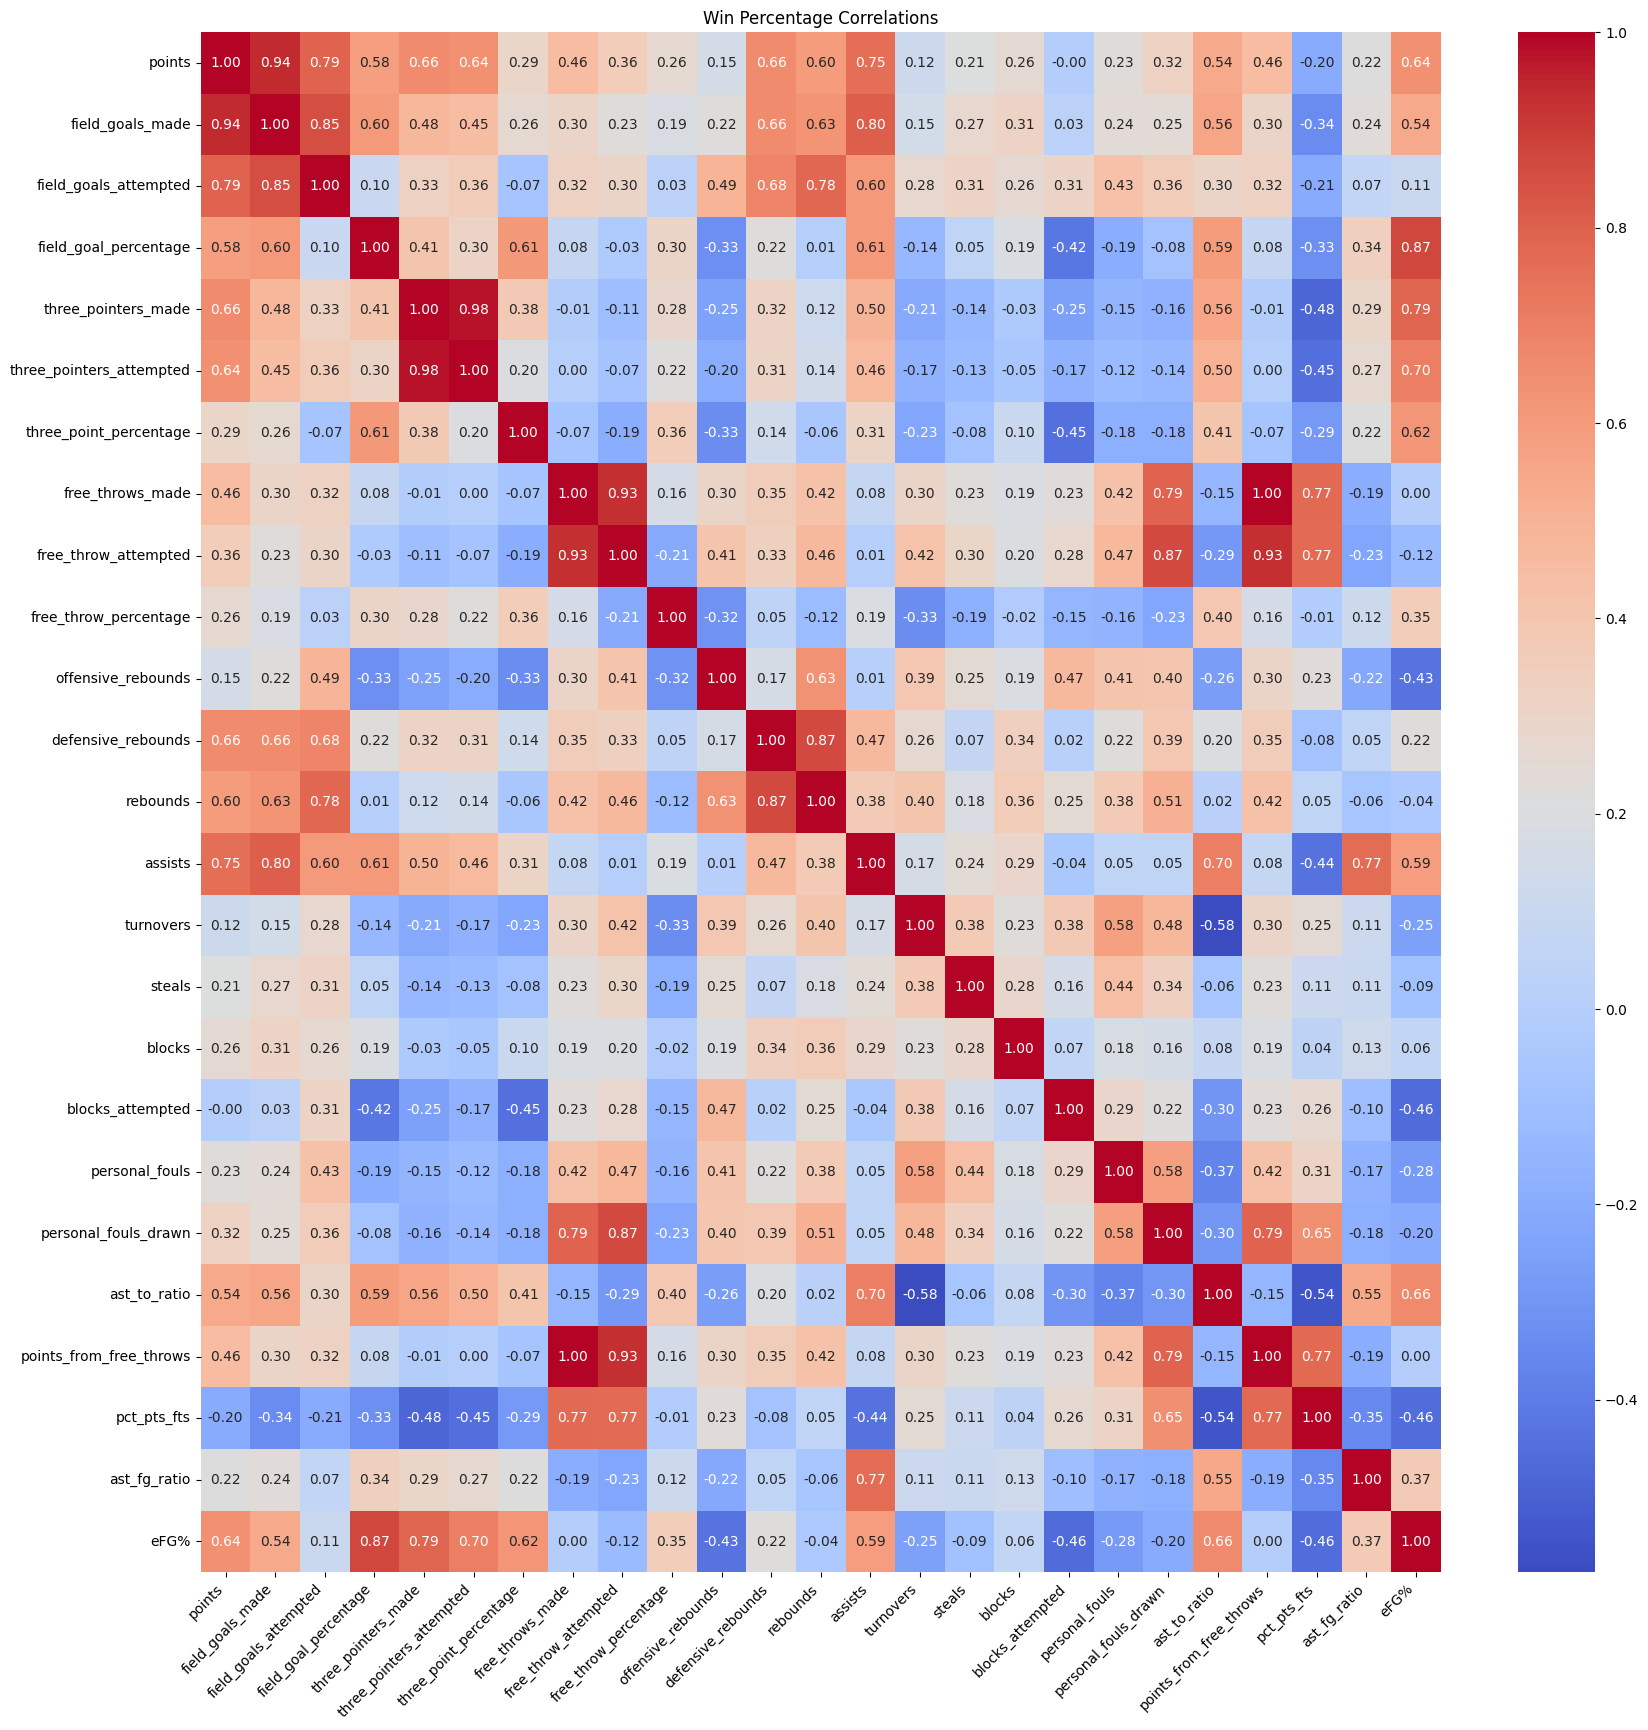

In [45]:
# Call the show_matrix function to display the correlation matrix
show_matrix(era2_matrix, 'Win Percentage')

In [46]:
# Display the strong correlations from the matrix of the entire dataset minus the target variable
print(era2_strong_correlations)

                  Feature1                  Feature2  Correlation
1                   points          field_goals_made     0.943302
27        field_goals_made     field_goals_attempted     0.852854
38        field_goals_made                   assists     0.803910
99   field_goal_percentage                      eFG%     0.871867
105    three_pointers_made  three_pointers_attempted     0.980790
183       free_throws_made      free_throw_attempted     0.930080
196       free_throws_made   points_from_free_throws     1.000000
219   free_throw_attempted      personal_fouls_drawn     0.870315
221   free_throw_attempted   points_from_free_throws     0.930080
287     defensive_rebounds                  rebounds     0.870113


In [47]:
# Call the drop_redundant_feats function on the dataset
era2_features = drop_redundant_feats(era2_strong_correlations, era2_features)

era2_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   field_goals_attempted     360 non-null    int64  
 1   three_pointers_attempted  360 non-null    int64  
 2   three_point_percentage    360 non-null    float64
 3   free_throw_percentage     360 non-null    float64
 4   offensive_rebounds        360 non-null    int64  
 5   rebounds                  360 non-null    int64  
 6   assists                   360 non-null    int64  
 7   turnovers                 360 non-null    int64  
 8   steals                    360 non-null    int64  
 9   blocks                    360 non-null    int64  
 10  blocks_attempted          360 non-null    int64  
 11  personal_fouls            360 non-null    int64  
 12  personal_fouls_drawn      360 non-null    int64  
 13  ast_to_ratio              360 non-null    float64
 14  points_from_fre

In [48]:
# Generate the matrix for the reduced features with the gen_corr_matrix function
red_era2_matrix, red_era2_strong_correlations = gen_corr_matrix(era2_features)
red_era2_strong_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [49]:
# Drop the field_goals_attempted, assists, turnovers, and points_from_free_throws features, as these can be accounted for in other features
era2_features = era2_features.drop(['field_goals_attempted', 'assists', 'turnovers', 'points_from_free_throws'], axis=1)

era2_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  360 non-null    int64  
 1   three_point_percentage    360 non-null    float64
 2   free_throw_percentage     360 non-null    float64
 3   offensive_rebounds        360 non-null    int64  
 4   rebounds                  360 non-null    int64  
 5   steals                    360 non-null    int64  
 6   blocks                    360 non-null    int64  
 7   blocks_attempted          360 non-null    int64  
 8   personal_fouls            360 non-null    int64  
 9   personal_fouls_drawn      360 non-null    int64  
 10  ast_to_ratio              360 non-null    float64
 11  pct_pts_fts               360 non-null    float64
 12  ast_fg_ratio              360 non-null    float64
 13  eFG%                      360 non-null    float64
dtypes: float64(6), 

In [50]:
# Drop the personal_fouls_drawn feature to more accurately compare the data between the two eras
era2_features = era2_features.drop(['personal_fouls_drawn'], axis=1)

era2_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  360 non-null    int64  
 1   three_point_percentage    360 non-null    float64
 2   free_throw_percentage     360 non-null    float64
 3   offensive_rebounds        360 non-null    int64  
 4   rebounds                  360 non-null    int64  
 5   steals                    360 non-null    int64  
 6   blocks                    360 non-null    int64  
 7   blocks_attempted          360 non-null    int64  
 8   personal_fouls            360 non-null    int64  
 9   ast_to_ratio              360 non-null    float64
 10  pct_pts_fts               360 non-null    float64
 11  ast_fg_ratio              360 non-null    float64
 12  eFG%                      360 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 39.4 KB


In [51]:
# Create a copy of the dataset for later use
era2_feats_master = era2_features.copy()

In [52]:
# Define the target variable for the dataset
y = df_era2['win_percentage']

# Train the model for the dataset
results_era2, era2_features = gen_lasso_model(era2_features, y)

Best Alpha: 0.0005
Y Measurables: 
count    360.000000
mean       0.499572
std        0.148145
min        0.122000
25%        0.390000
50%        0.512000
75%        0.610000
max        0.890000
Name: win_percentage, dtype: float64
Training RMSE: 0.08059673278271494, Testing RMSE: 0.08719931902973677
Training R^2: 0.6965764426769753, Testing R^2: 0.680052778765021
Non-zero Coefficients: 
rebounds                    0.055040
three_point_percentage      0.047809
eFG%                        0.047179
steals                      0.036885
pct_pts_fts                 0.036861
ast_to_ratio                0.011146
blocks                      0.009237
offensive_rebounds          0.004430
free_throw_percentage       0.003466
ast_fg_ratio               -0.007062
three_pointers_attempted   -0.021997
personal_fouls             -0.035107
blocks_attempted           -0.049688
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  3.048134
1     

In [53]:
# Drop the ast_to_ratio feature to reducs vif scores
era2_features = era2_features.drop(['ast_to_ratio'], axis=1)

era2_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  360 non-null    int64  
 1   three_point_percentage    360 non-null    float64
 2   free_throw_percentage     360 non-null    float64
 3   offensive_rebounds        360 non-null    int64  
 4   rebounds                  360 non-null    int64  
 5   steals                    360 non-null    int64  
 6   blocks                    360 non-null    int64  
 7   blocks_attempted          360 non-null    int64  
 8   personal_fouls            360 non-null    int64  
 9   pct_pts_fts               360 non-null    float64
 10  ast_fg_ratio              360 non-null    float64
 11  eFG%                      360 non-null    float64
dtypes: float64(5), int64(7)
memory usage: 36.6 KB


In [54]:
# Retrain the model
results_era2, era2_features = gen_lasso_model(era2_features, y)

Best Alpha: 0.0001
Y Measurables: 
count    360.000000
mean       0.499572
std        0.148145
min        0.122000
25%        0.390000
50%        0.512000
75%        0.610000
max        0.890000
Name: win_percentage, dtype: float64
Training RMSE: 0.08084516427181536, Testing RMSE: 0.08804641459310561
Training R^2: 0.6947030133398976, Testing R^2: 0.6738063467604251
Non-zero Coefficients: 
rebounds                    0.056547
eFG%                        0.053239
three_point_percentage      0.046517
steals                      0.038379
pct_pts_fts                 0.034300
blocks                      0.009098
free_throw_percentage       0.007047
offensive_rebounds          0.006696
ast_fg_ratio               -0.004424
three_pointers_attempted   -0.023544
personal_fouls             -0.038639
blocks_attempted           -0.050678
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  3.047752
1     three_point_percentage  2.226386
2  

In [55]:
# With feature selection finalized, create a series of regression coefficients
era2_coefficients = pd.Series(results_era2['non_zero_coefficients'])

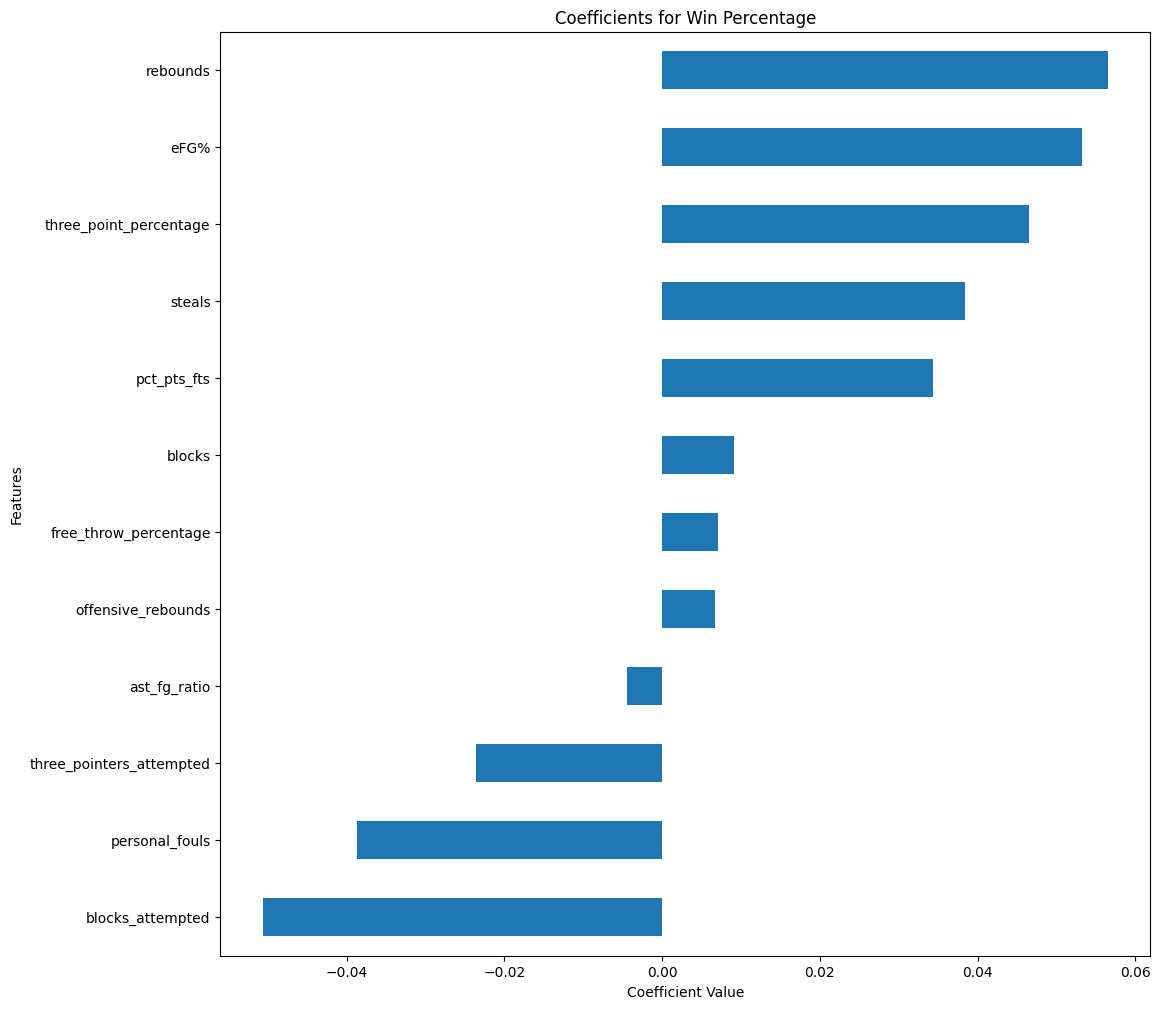

In [56]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(era2_coefficients, 'Win Percentage')

In [57]:
# Generate bootstrap coefficients 
bootstrap_results_era2 = gen_bootstrap_coefficients(
    results_era2['model'], results_era2['X'], results_era2['y'], results_era2['feature_names']
)

Average Y: 0.49957222222222225
Average Training RMSE: 0.0801951218211978, Average Testing RMSE: 0.0829439118682663
Average Training R^2: 0.7046405827913814, Average Testing R^2: 0.6744692935412823
Sorted Coefficients: 
                              Mean    StdDev  CI Lower  CI Upper
eFG%                      0.065885  0.011207  0.044002  0.087013
rebounds                  0.054302  0.007033  0.039930  0.067721
three_point_percentage    0.040616  0.007426  0.026131  0.055254
steals                    0.039630  0.005856  0.028507  0.051063
pct_pts_fts               0.033193  0.006106  0.022013  0.044834
blocks                    0.007804  0.005819 -0.003056  0.019923
free_throw_percentage     0.006503  0.005431 -0.003781  0.016813
offensive_rebounds        0.006046  0.007983 -0.008720  0.022155
ast_fg_ratio             -0.007648  0.005867 -0.018730  0.003536
three_pointers_attempted -0.030673  0.009442 -0.048364 -0.012834
personal_fouls           -0.034698  0.006393 -0.046728 -0.022190
b

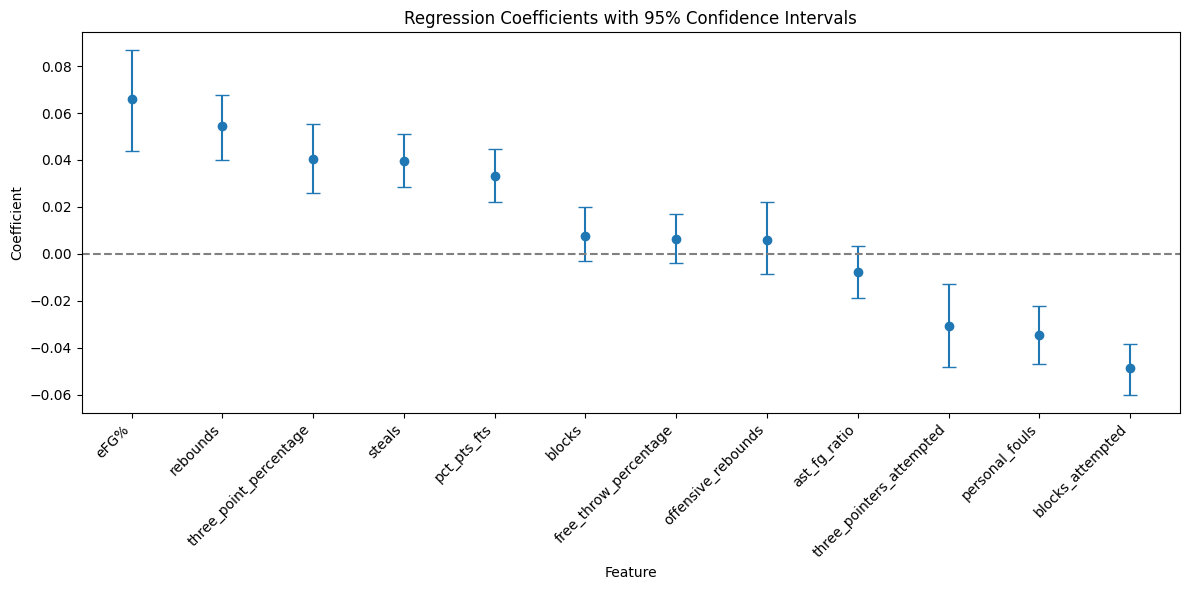

In [58]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_era2)

In [59]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_era2, era2_features)

A 0.010 unit increase in eFG% results in an approximate 0.0271 (or 2.71 percentage points) change in the target variable.
A 70.114 unit increase in rebounds results in an approximate 0.0171 (or 1.71 percentage points) change in the target variable.
A 0.007 unit increase in three_point_percentage results in an approximate 0.0172 (or 1.72 percentage points) change in the target variable.
A 12.265 unit increase in steals results in an approximate 0.0068 (or 0.68 percentage points) change in the target variable.
A 0.003 unit increase in pct_pts_fts results in an approximate 0.0067 (or 0.67 percentage points) change in the target variable.
A 46.503 unit increase in three_pointers_attempted results in an approximate -0.0028 (or -0.28 percentage points) change in the target variable.
A 32.094 unit increase in personal_fouls results in an approximate -0.0079 (or -0.79 percentage points) change in the target variable.
A 7.805 unit increase in blocks_attempted results in an approximate -0.0064 (

In [60]:
# Repeat the process above with each selected feature as the target variable, starting with eFG%

In [61]:
# Check the df_feats_master DataFrame
era2_feats_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  360 non-null    int64  
 1   three_point_percentage    360 non-null    float64
 2   free_throw_percentage     360 non-null    float64
 3   offensive_rebounds        360 non-null    int64  
 4   rebounds                  360 non-null    int64  
 5   steals                    360 non-null    int64  
 6   blocks                    360 non-null    int64  
 7   blocks_attempted          360 non-null    int64  
 8   personal_fouls            360 non-null    int64  
 9   ast_to_ratio              360 non-null    float64
 10  pct_pts_fts               360 non-null    float64
 11  ast_fg_ratio              360 non-null    float64
 12  eFG%                      360 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 39.4 KB


In [62]:
# Drop the target variable from the features
efg_feats_era2 = era2_feats_master.drop(['eFG%'], axis=1)

efg_feats_era2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  360 non-null    int64  
 1   three_point_percentage    360 non-null    float64
 2   free_throw_percentage     360 non-null    float64
 3   offensive_rebounds        360 non-null    int64  
 4   rebounds                  360 non-null    int64  
 5   steals                    360 non-null    int64  
 6   blocks                    360 non-null    int64  
 7   blocks_attempted          360 non-null    int64  
 8   personal_fouls            360 non-null    int64  
 9   ast_to_ratio              360 non-null    float64
 10  pct_pts_fts               360 non-null    float64
 11  ast_fg_ratio              360 non-null    float64
dtypes: float64(5), int64(7)
memory usage: 36.6 KB


In [63]:
# Generate the matrix for the base features of the full dataset minus the target feature and win percentage with the gen_corr_matrix function
efg_era2_feature_matrix, efg_era2_feat_str_correlations = gen_corr_matrix(efg_feats_era2)

efg_era2_feat_str_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [64]:
# Define the target variable for the dataset
y_efg_era2 = era2_feats_master['eFG%']

# Train the model for the dataset
results_efg_era2, efg_feats_era2 = gen_lasso_model(efg_feats_era2, y_efg_era2)

Best Alpha: 0.0001
Y Measurables: 
count    360.000000
mean       0.520468
std        0.025337
min        0.456145
25%        0.501530
50%        0.521537
75%        0.538119
max        0.578497
Name: eFG%, dtype: float64
Training RMSE: 0.01060475439487678, Testing RMSE: 0.013166563607013355
Training R^2: 0.8190349222161808, Testing R^2: 0.7558206043191031
Non-zero Coefficients: 
three_pointers_attempted    0.013020
three_point_percentage      0.009053
ast_to_ratio                0.004192
blocks                      0.001711
steals                      0.001475
ast_fg_ratio                0.000182
personal_fouls             -0.000909
blocks_attempted           -0.002607
offensive_rebounds         -0.003245
dtype: float64
Variance Inflation Factors: 
                    feature       vif
0  three_pointers_attempted  1.408017
1    three_point_percentage  1.452535
2        offensive_rebounds  1.568070
3                    steals  1.392628
4                    blocks  1.171383
5          b

In [65]:
# With feature selection finalized, create a series of regression coefficients
efg_era2_coefficients = pd.Series(results_efg_era2['non_zero_coefficients'])

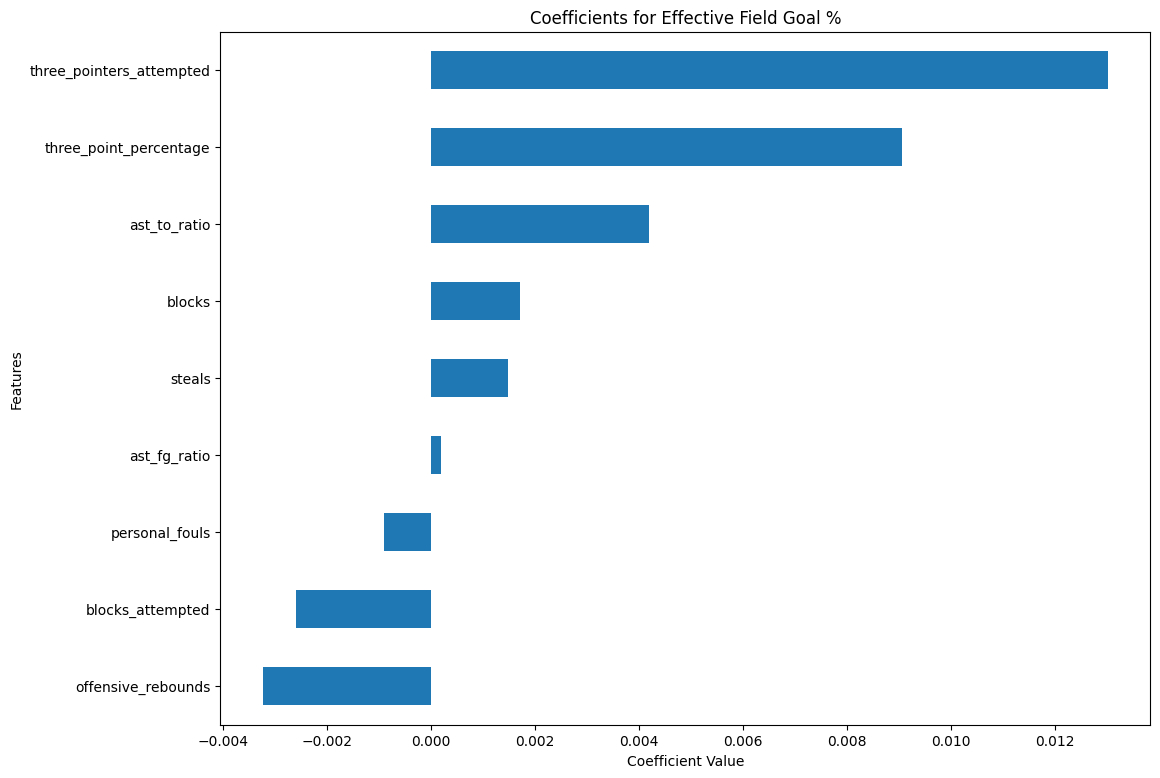

In [66]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(efg_era2_coefficients, 'Effective Field Goal %')

In [67]:
# Generate bootstrap coefficients 
bootstrap_results_efg_era2 = gen_bootstrap_coefficients(
    results_efg_era2['model'], results_efg_era2['X'], results_efg_era2['y'], results_efg_era2['feature_names']
)

Average Y: 0.5204678068675845
Average Training RMSE: 0.010955455813874231, Average Testing RMSE: 0.011308014941716918
Average Training R^2: 0.8104023989557817, Average Testing R^2: 0.7948984913409838
Sorted Coefficients: 
                              Mean    StdDev  CI Lower  CI Upper
three_pointers_attempted  0.012551  0.000782  0.011037  0.014197
three_point_percentage    0.008781  0.000760  0.007366  0.010209
ast_to_ratio              0.004617  0.000957  0.002740  0.006345
blocks                    0.001502  0.000744  0.000000  0.002937
steals                    0.001401  0.000749  0.000000  0.002874
ast_fg_ratio              0.000202  0.000620 -0.000979  0.001596
personal_fouls           -0.000946  0.000821 -0.002672  0.000416
blocks_attempted         -0.002789  0.000905 -0.004456 -0.001041
offensive_rebounds       -0.002993  0.000849 -0.004564 -0.001316


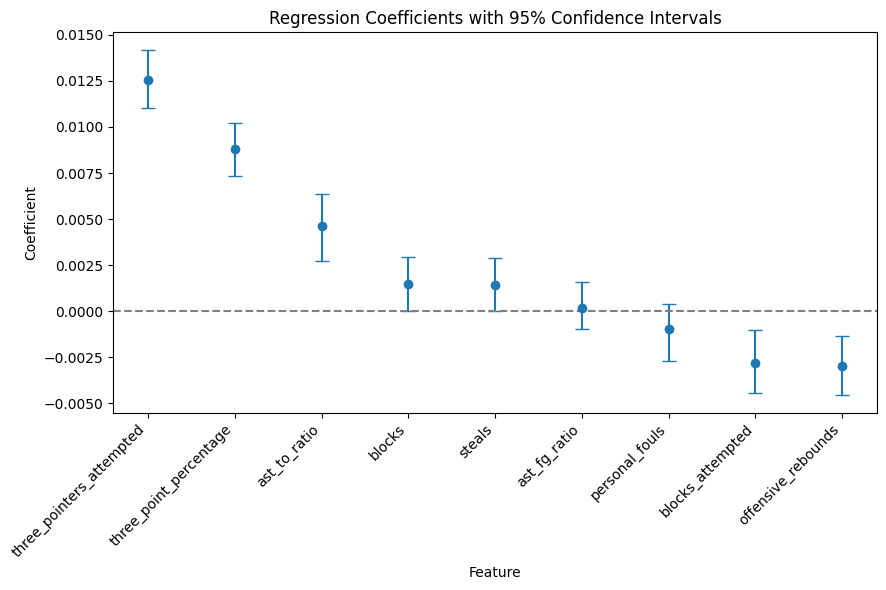

In [68]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_efg_era2)

In [69]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_efg_era2, efg_feats_era2)

A 46.503 unit increase in three_pointers_attempted results in an approximate 0.0011 (or 0.11 percentage points) change in the target variable.
A 0.007 unit increase in three_point_percentage results in an approximate 0.0037 (or 0.37 percentage points) change in the target variable.
A 0.034 unit increase in ast_to_ratio results in an approximate 0.0007 (or 0.07 percentage points) change in the target variable.
A 7.805 unit increase in blocks_attempted results in an approximate -0.0004 (or -0.04 percentage points) change in the target variable.
A 16.701 unit increase in offensive_rebounds results in an approximate -0.0004 (or -0.04 percentage points) change in the target variable.


In [70]:
# Continue with secondary feature regression analysis using rebounds as the target variable

In [71]:
# Check the df_feats_master DataFrame
era2_feats_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  360 non-null    int64  
 1   three_point_percentage    360 non-null    float64
 2   free_throw_percentage     360 non-null    float64
 3   offensive_rebounds        360 non-null    int64  
 4   rebounds                  360 non-null    int64  
 5   steals                    360 non-null    int64  
 6   blocks                    360 non-null    int64  
 7   blocks_attempted          360 non-null    int64  
 8   personal_fouls            360 non-null    int64  
 9   ast_to_ratio              360 non-null    float64
 10  pct_pts_fts               360 non-null    float64
 11  ast_fg_ratio              360 non-null    float64
 12  eFG%                      360 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 39.4 KB


In [72]:
# Drop the target variable from the features
reb_feats_era2 = era2_feats_master.drop(['rebounds'], axis=1)

reb_feats_era2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  360 non-null    int64  
 1   three_point_percentage    360 non-null    float64
 2   free_throw_percentage     360 non-null    float64
 3   offensive_rebounds        360 non-null    int64  
 4   steals                    360 non-null    int64  
 5   blocks                    360 non-null    int64  
 6   blocks_attempted          360 non-null    int64  
 7   personal_fouls            360 non-null    int64  
 8   ast_to_ratio              360 non-null    float64
 9   pct_pts_fts               360 non-null    float64
 10  ast_fg_ratio              360 non-null    float64
 11  eFG%                      360 non-null    float64
dtypes: float64(6), int64(6)
memory usage: 36.6 KB


In [73]:
# Generate the matrix for the base features of the full dataset minus the target feature and win percentage with the gen_corr_matrix function
reb_era2_feature_matrix, reb_era2_feat_str_correlations = gen_corr_matrix(reb_feats_era2)

reb_era2_feat_str_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [74]:
# Drop the offensive_rebounds feature
reb_feats_era2 = reb_feats_era2.drop(['offensive_rebounds'], axis=1)

reb_feats_era2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  360 non-null    int64  
 1   three_point_percentage    360 non-null    float64
 2   free_throw_percentage     360 non-null    float64
 3   steals                    360 non-null    int64  
 4   blocks                    360 non-null    int64  
 5   blocks_attempted          360 non-null    int64  
 6   personal_fouls            360 non-null    int64  
 7   ast_to_ratio              360 non-null    float64
 8   pct_pts_fts               360 non-null    float64
 9   ast_fg_ratio              360 non-null    float64
 10  eFG%                      360 non-null    float64
dtypes: float64(6), int64(5)
memory usage: 33.8 KB


In [75]:
# Define the target variable for the dataset
y_reb_era2 = era2_feats_master['rebounds']

# Train the model for the dataset
results_reb_era2, reb_feats_era2 = gen_lasso_model(reb_feats_era2, y_reb_era2)

Best Alpha: 0.1
Y Measurables: 
count     360.000000
mean     3505.686111
std       223.356601
min      2721.000000
25%      3386.000000
50%      3531.500000
75%      3650.500000
max      4078.000000
Name: rebounds, dtype: float64
Training RMSE: 177.12826791560047, Testing RMSE: 180.78269184756505
Training R^2: 0.3603402244899955, Testing R^2: 0.37787503301478853
Non-zero Coefficients: 
three_pointers_attempted    77.433404
blocks                      73.784708
ast_to_ratio                69.512984
personal_fouls              66.110989
blocks_attempted            37.138851
three_point_percentage      22.271854
pct_pts_fts                 19.455344
steals                      -9.451750
ast_fg_ratio               -40.675013
free_throw_percentage      -42.918897
eFG%                       -56.832983
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  2.855885
1     three_point_percentage  2.212890
2      free_throw_percentage  1

In [76]:
# Drop the three_point_percentage feature to reduce vif scores
reb_feats_era2 = reb_feats_era2.drop(['three_point_percentage'], axis=1)

reb_feats_era2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  360 non-null    int64  
 1   free_throw_percentage     360 non-null    float64
 2   steals                    360 non-null    int64  
 3   blocks                    360 non-null    int64  
 4   blocks_attempted          360 non-null    int64  
 5   personal_fouls            360 non-null    int64  
 6   ast_to_ratio              360 non-null    float64
 7   pct_pts_fts               360 non-null    float64
 8   ast_fg_ratio              360 non-null    float64
 9   eFG%                      360 non-null    float64
dtypes: float64(5), int64(5)
memory usage: 30.9 KB


In [77]:
# Retrain the model
results_reb_era2, reb_feats_era2 = gen_lasso_model(reb_feats_era2, y_reb_era2)

Best Alpha: 0.0001
Y Measurables: 
count     360.000000
mean     3505.686111
std       223.356601
min      2721.000000
25%      3386.000000
50%      3531.500000
75%      3650.500000
max      4078.000000
Name: rebounds, dtype: float64
Training RMSE: 177.74437098767362, Testing RMSE: 183.14791647849518
Training R^2: 0.35588264414256343, Testing R^2: 0.3614897136865761
Non-zero Coefficients: 
blocks                      74.540572
ast_to_ratio                68.753101
personal_fouls              68.549377
three_pointers_attempted    66.953432
blocks_attempted            34.596561
pct_pts_fts                 16.576652
steals                     -10.540943
eFG%                       -38.319015
free_throw_percentage      -39.478376
ast_fg_ratio               -41.274518
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  2.373709
1      free_throw_percentage  1.391311
2                     steals  1.432903
3                     block

In [78]:
# With feature selection finalized, create a series of regression coefficients
reb_era2_coefficients = pd.Series(results_reb_era2['non_zero_coefficients'])

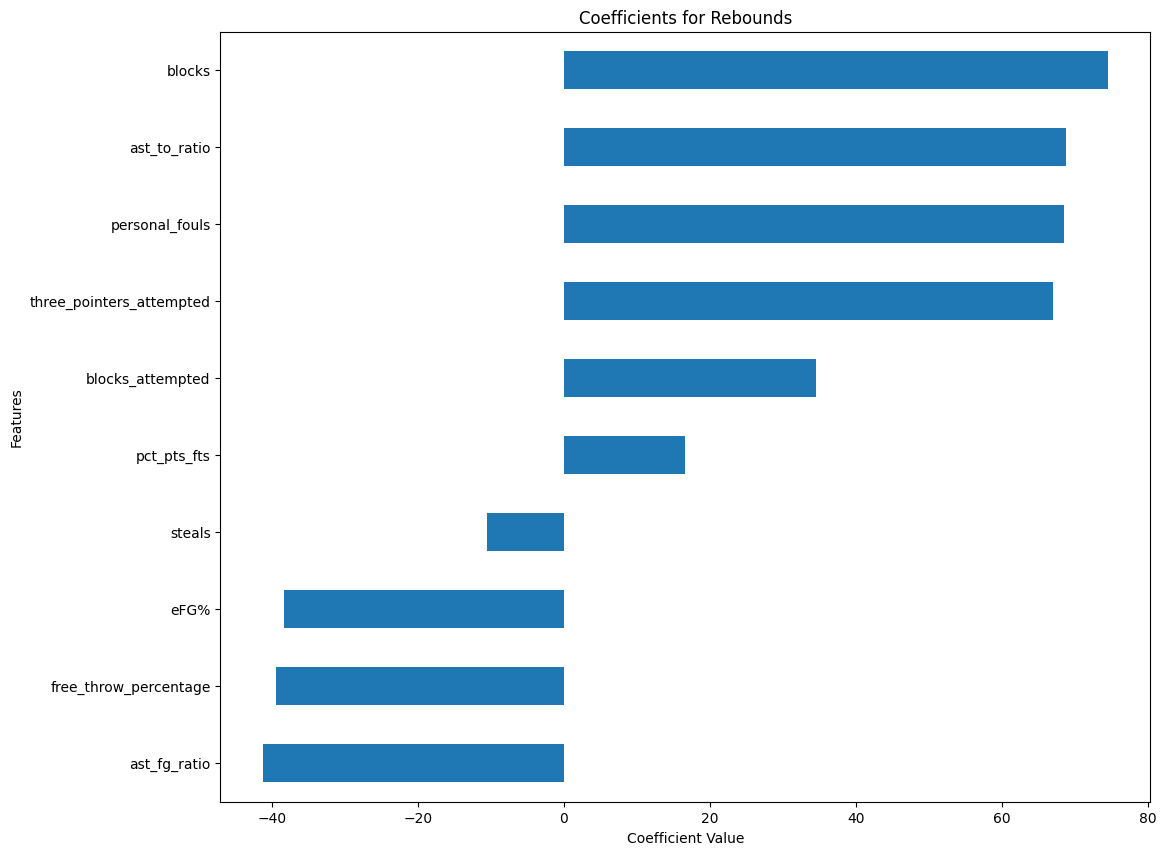

In [79]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(reb_era2_coefficients, 'Rebounds')

In [80]:
# Generate bootstrap coefficients 
bootstrap_results_reb_era2 = gen_bootstrap_coefficients(
    results_reb_era2['model'], results_reb_era2['X'], results_reb_era2['y'], results_reb_era2['feature_names']
)

Average Y: 3505.686111111111
Average Training RMSE: 175.14808034002857, Average Testing RMSE: 180.4010060462767
Average Training R^2: 0.3784868961461675, Average Testing R^2: 0.3085488584727273
Sorted Coefficients: 
                               Mean     StdDev   CI Lower    CI Upper
personal_fouls            74.869430  15.484030  45.338735  104.773459
blocks                    72.395784  11.792262  48.959883   95.583581
ast_to_ratio              71.200563  18.953826  33.353220  108.296790
three_pointers_attempted  63.287234  16.993544  31.772345   98.092479
blocks_attempted          34.051930  12.796793   8.860261   59.169298
pct_pts_fts               14.657812  13.356939 -12.457743   39.589917
steals                   -12.749536  13.120450 -38.376101   11.935445
eFG%                     -35.423219  18.863683 -72.008307    2.303343
free_throw_percentage    -36.402702  13.009729 -63.373247  -12.225427
ast_fg_ratio             -38.681471  13.585016 -66.355252  -12.205096


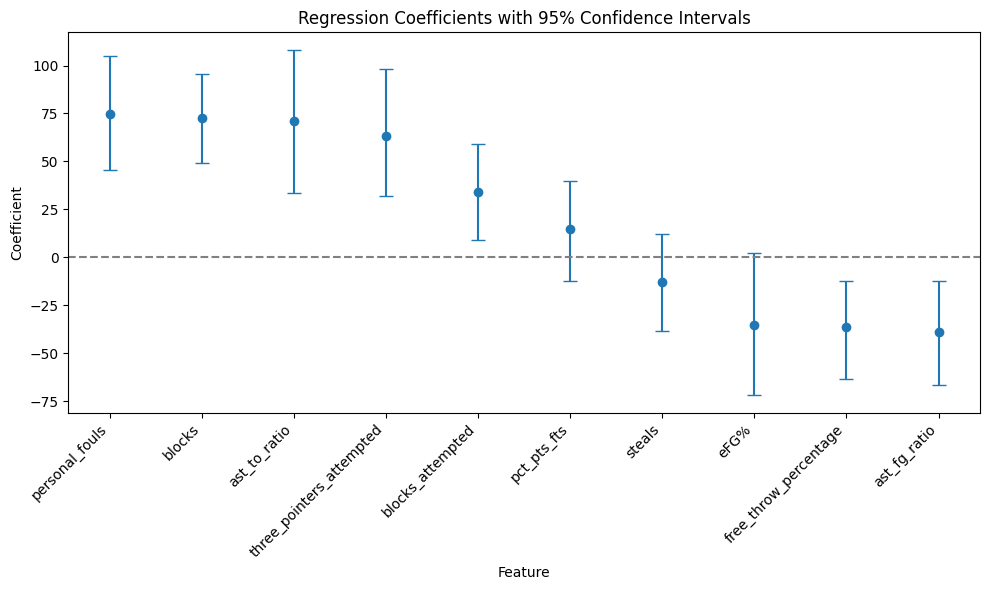

In [81]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_reb_era2)

In [82]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_reb_era2, reb_feats_era2, False)

A 32.094 unit increase in personal_fouls results in an approximate 17.142 change in the target variable.
A 7.805 unit increase in blocks results in an approximate 8.889 change in the target variable.
A 0.034 unit increase in ast_to_ratio results in an approximate 11.201 change in the target variable.
A 46.503 unit increase in three_pointers_attempted results in an approximate 5.684 change in the target variable.
A 7.805 unit increase in blocks_attempted results in an approximate 4.451 change in the target variable.
A 0.015 unit increase in free_throw_percentage results in an approximate -18.424 change in the target variable.
A 0.012 unit increase in ast_fg_ratio results in an approximate -11.928 change in the target variable.


In [83]:
# Continue with secondary feature regression analysis using three_point_percentage as the target variable

In [84]:
# Check the df_feats_master DataFrame
era2_feats_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  360 non-null    int64  
 1   three_point_percentage    360 non-null    float64
 2   free_throw_percentage     360 non-null    float64
 3   offensive_rebounds        360 non-null    int64  
 4   rebounds                  360 non-null    int64  
 5   steals                    360 non-null    int64  
 6   blocks                    360 non-null    int64  
 7   blocks_attempted          360 non-null    int64  
 8   personal_fouls            360 non-null    int64  
 9   ast_to_ratio              360 non-null    float64
 10  pct_pts_fts               360 non-null    float64
 11  ast_fg_ratio              360 non-null    float64
 12  eFG%                      360 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 39.4 KB


In [85]:
# Drop the target variable from the features
tpp_feats_era2 = era2_feats_master.drop(['three_point_percentage'], axis=1)

tpp_feats_era2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  360 non-null    int64  
 1   free_throw_percentage     360 non-null    float64
 2   offensive_rebounds        360 non-null    int64  
 3   rebounds                  360 non-null    int64  
 4   steals                    360 non-null    int64  
 5   blocks                    360 non-null    int64  
 6   blocks_attempted          360 non-null    int64  
 7   personal_fouls            360 non-null    int64  
 8   ast_to_ratio              360 non-null    float64
 9   pct_pts_fts               360 non-null    float64
 10  ast_fg_ratio              360 non-null    float64
 11  eFG%                      360 non-null    float64
dtypes: float64(5), int64(7)
memory usage: 36.6 KB


In [86]:
# Generate the matrix for the base features of the full dataset minus the target feature and win percentage with the gen_corr_matrix function
tpp_era2_feature_matrix, tpp_era2_feat_str_correlations = gen_corr_matrix(tpp_feats_era2)

tpp_era2_feat_str_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [87]:
# Drop the eFG% feature from the dataset
tpp_feats_era2 = tpp_feats_era2.drop(['eFG%'], axis=1)

tpp_feats_era2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  360 non-null    int64  
 1   free_throw_percentage     360 non-null    float64
 2   offensive_rebounds        360 non-null    int64  
 3   rebounds                  360 non-null    int64  
 4   steals                    360 non-null    int64  
 5   blocks                    360 non-null    int64  
 6   blocks_attempted          360 non-null    int64  
 7   personal_fouls            360 non-null    int64  
 8   ast_to_ratio              360 non-null    float64
 9   pct_pts_fts               360 non-null    float64
 10  ast_fg_ratio              360 non-null    float64
dtypes: float64(4), int64(7)
memory usage: 33.8 KB


In [88]:
# Define the target variable for the dataset
y_tpp_era2 = era2_feats_master['three_point_percentage']

# Train the model for the dataset
results_tpp_era2, tpp_feats_era2 = gen_lasso_model(tpp_feats_era2, y_tpp_era2)

Best Alpha: 0.0005
Y Measurables: 
count    360.000000
mean       0.357981
std        0.016917
min        0.305000
25%        0.347000
50%        0.357000
75%        0.370000
max        0.416000
Name: three_point_percentage, dtype: float64
Training RMSE: 0.013308493676561855, Testing RMSE: 0.015139947854118195
Training R^2: 0.32900014293005786, Testing R^2: 0.3815516655611513
Non-zero Coefficients: 
free_throw_percentage    0.003481
ast_to_ratio             0.001740
blocks                   0.001689
ast_fg_ratio             0.000086
steals                   0.000046
offensive_rebounds      -0.000350
pct_pts_fts             -0.001668
blocks_attempted        -0.005318
dtype: float64
Variance Inflation Factors: 
                 feature       vif
0  free_throw_percentage  1.439287
1     offensive_rebounds  1.555130
2                 steals  1.200045
3                 blocks  1.139719
4       blocks_attempted  1.388848
5           ast_to_ratio  2.371408
6            pct_pts_fts  1.602086
7

In [89]:
# With feature selection finalized, create a series of regression coefficients
tpp_era2_coefficients = pd.Series(results_tpp_era2['non_zero_coefficients'])

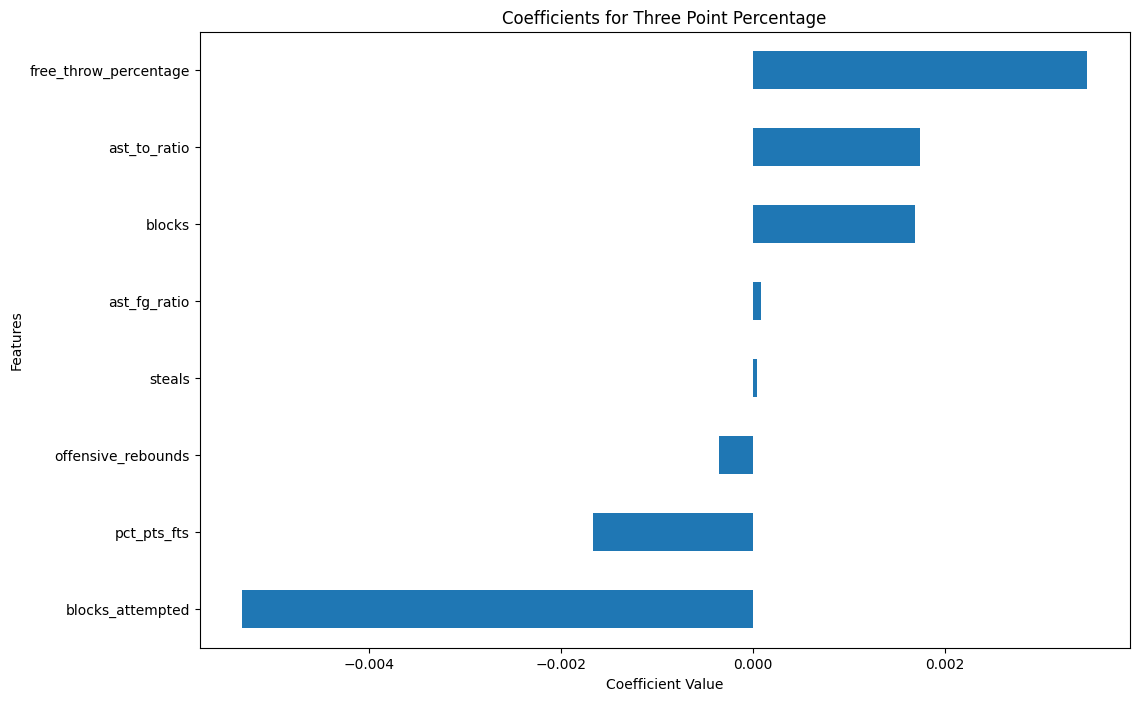

In [90]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(tpp_era2_coefficients, 'Three Point Percentage')

In [91]:
# Generate bootstrap coefficients 
bootstrap_results_tpp_era2 = gen_bootstrap_coefficients(
    results_tpp_era2['model'], results_tpp_era2['X'], results_tpp_era2['y'], results_tpp_era2['feature_names']
)

Average Y: 0.3579805555555555
Average Training RMSE: 0.013412317953414665, Average Testing RMSE: 0.01375433857027938
Average Training R^2: 0.3628213097816863, Average Testing R^2: 0.31162342860413367
Sorted Coefficients: 
                           Mean    StdDev  CI Lower  CI Upper
free_throw_percentage  0.003730  0.000941  0.001932  0.005550
ast_to_ratio           0.001859  0.001028  0.000000  0.003785
blocks                 0.001661  0.000832  0.000106  0.003346
ast_fg_ratio           0.000369  0.000696 -0.000673  0.002129
steals                 0.000091  0.000487 -0.000943  0.001312
offensive_rebounds    -0.000904  0.000804 -0.002637  0.000000
pct_pts_fts           -0.001712  0.000982 -0.003645  0.000000
blocks_attempted      -0.005118  0.000947 -0.006865 -0.003192


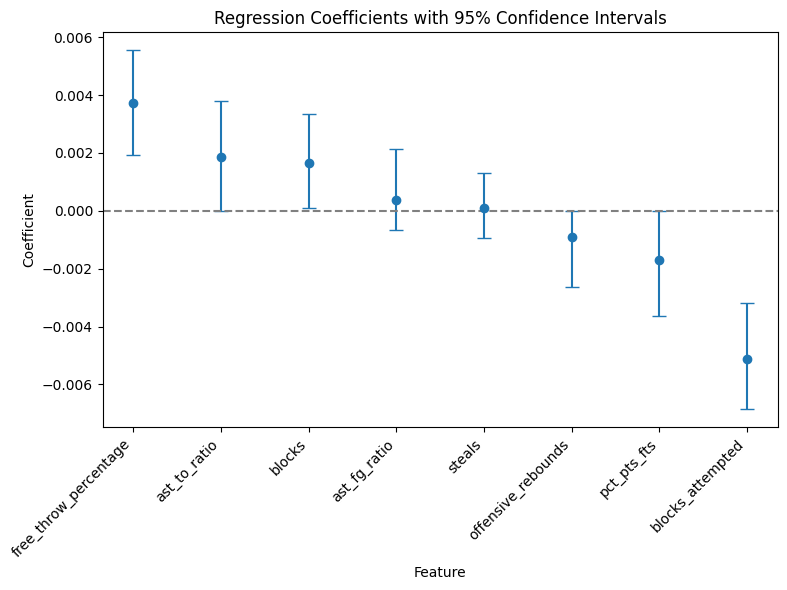

In [92]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_tpp_era2)

In [93]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_tpp_era2, tpp_feats_era2)

A 0.015 unit increase in free_throw_percentage results in an approximate 0.0019 (or 0.19 percentage points) change in the target variable.
A 7.805 unit increase in blocks results in an approximate 0.0002 (or 0.02 percentage points) change in the target variable.
A 7.805 unit increase in blocks_attempted results in an approximate -0.0007 (or -0.07 percentage points) change in the target variable.


In [94]:
# Continue with secondary feature regression analysis using steals as the target variable

In [95]:
# Check the df_feats_master DataFrame
era2_feats_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  360 non-null    int64  
 1   three_point_percentage    360 non-null    float64
 2   free_throw_percentage     360 non-null    float64
 3   offensive_rebounds        360 non-null    int64  
 4   rebounds                  360 non-null    int64  
 5   steals                    360 non-null    int64  
 6   blocks                    360 non-null    int64  
 7   blocks_attempted          360 non-null    int64  
 8   personal_fouls            360 non-null    int64  
 9   ast_to_ratio              360 non-null    float64
 10  pct_pts_fts               360 non-null    float64
 11  ast_fg_ratio              360 non-null    float64
 12  eFG%                      360 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 39.4 KB


In [96]:
# Drop the target variable from the features
steals_feats_era2 = era2_feats_master.drop(['steals'], axis=1)

steals_feats_era2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  360 non-null    int64  
 1   three_point_percentage    360 non-null    float64
 2   free_throw_percentage     360 non-null    float64
 3   offensive_rebounds        360 non-null    int64  
 4   rebounds                  360 non-null    int64  
 5   blocks                    360 non-null    int64  
 6   blocks_attempted          360 non-null    int64  
 7   personal_fouls            360 non-null    int64  
 8   ast_to_ratio              360 non-null    float64
 9   pct_pts_fts               360 non-null    float64
 10  ast_fg_ratio              360 non-null    float64
 11  eFG%                      360 non-null    float64
dtypes: float64(6), int64(6)
memory usage: 36.6 KB


In [97]:
# Generate the matrix for the base features of the full dataset minus the target feature and win percentage with the gen_corr_matrix function
steals_era2_feature_matrix, steals_era2_feat_str_correlations = gen_corr_matrix(steals_feats_era2)

steals_era2_feat_str_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [98]:
# Define the target variable for the dataset
y_steals_era2 = era2_feats_master['steals']

# Train the model for the dataset
results_steals_era2, steals_feats_era2 = gen_lasso_model(steals_feats_era2, y_steals_era2)

Best Alpha: 0.1
Y Measurables: 
count    360.000000
mean     613.241667
std       71.782633
min      428.000000
25%      564.500000
50%      612.000000
75%      664.500000
max      821.000000
Name: steals, dtype: float64
Training RMSE: 59.85101397513608, Testing RMSE: 58.9797557570913
Training R^2: 0.280322470851849, Testing R^2: 0.38410322656823637
Non-zero Coefficients: 
personal_fouls              31.033268
eFG%                        17.106223
ast_to_ratio                11.961529
blocks                      11.167004
offensive_rebounds           9.423634
ast_fg_ratio                 6.547593
blocks_attempted             5.604342
pct_pts_fts                  0.226683
three_point_percentage      -4.487904
rebounds                    -8.174392
free_throw_percentage       -9.656920
three_pointers_attempted   -15.269729
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  2.989294
1     three_point_percentage  2.229165
2      

In [99]:
# Drop the three_point_percentage feature to reduce vif scores
steals_feats_era2 = steals_feats_era2.drop(['three_point_percentage'], axis=1)

steals_feats_era2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  360 non-null    int64  
 1   free_throw_percentage     360 non-null    float64
 2   offensive_rebounds        360 non-null    int64  
 3   rebounds                  360 non-null    int64  
 4   blocks                    360 non-null    int64  
 5   blocks_attempted          360 non-null    int64  
 6   personal_fouls            360 non-null    int64  
 7   ast_to_ratio              360 non-null    float64
 8   pct_pts_fts               360 non-null    float64
 9   ast_fg_ratio              360 non-null    float64
 10  eFG%                      360 non-null    float64
dtypes: float64(5), int64(6)
memory usage: 33.8 KB


In [100]:
# Retrain the model
results_steals_era2, steals_feats_era2 = gen_lasso_model(steals_feats_era2, y_steals_era2)

Best Alpha: 0.1
Y Measurables: 
count    360.000000
mean     613.241667
std       71.782633
min      428.000000
25%      564.500000
50%      612.000000
75%      664.500000
max      821.000000
Name: steals, dtype: float64
Training RMSE: 59.93471151699435, Testing RMSE: 59.225768083383095
Training R^2: 0.27830822402310607, Testing R^2: 0.3789545379304292
Non-zero Coefficients: 
personal_fouls              30.763405
eFG%                        13.192998
ast_to_ratio                12.408925
blocks                      11.160281
offensive_rebounds           9.138122
ast_fg_ratio                 6.551119
blocks_attempted             6.238380
pct_pts_fts                  0.907423
rebounds                    -8.335395
free_throw_percentage      -10.532736
three_pointers_attempted   -13.046268
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  2.466755
1      free_throw_percentage  1.438578
2         offensive_rebounds  2.557665
3  

In [101]:
# With feature selection finalized, create a series of regression coefficients
steals_era2_coefficients = pd.Series(results_steals_era2['non_zero_coefficients'])

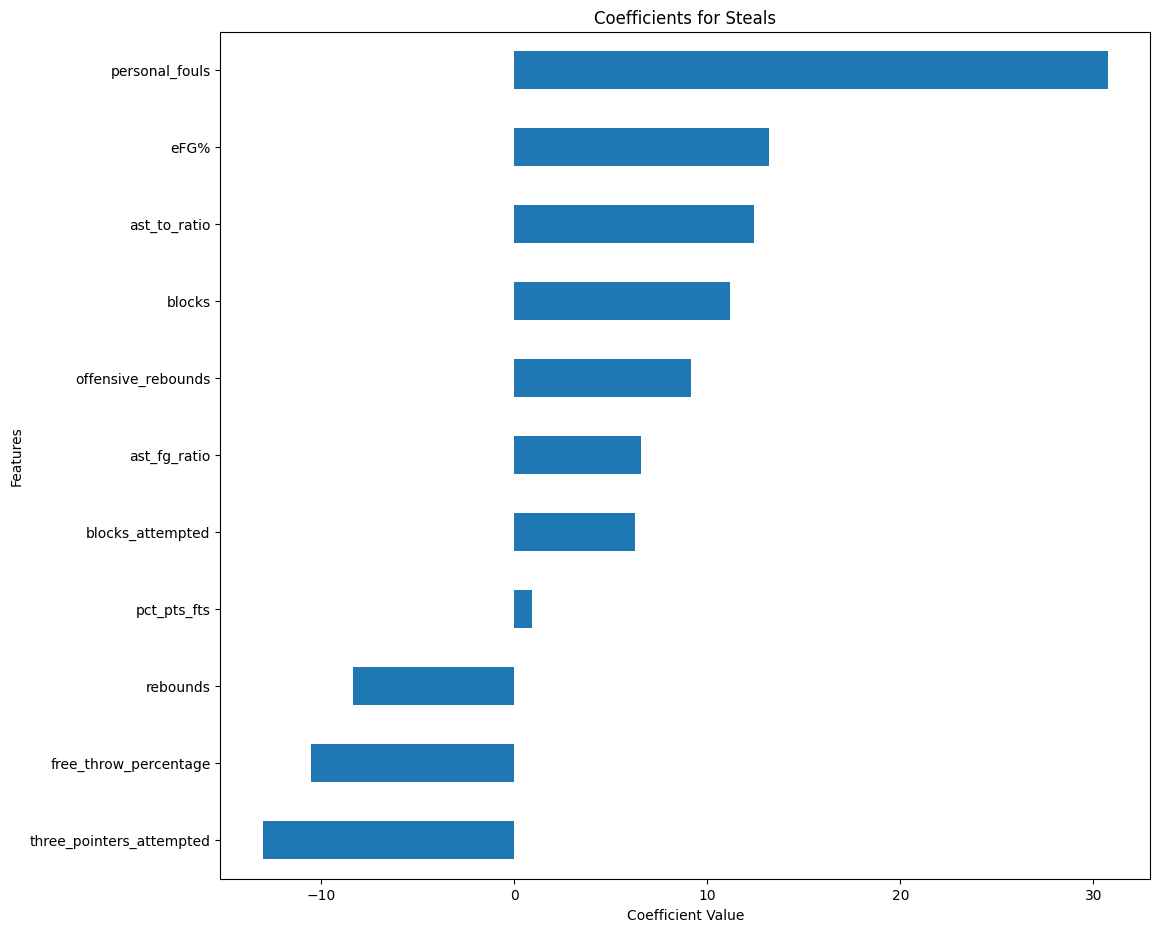

In [102]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(steals_era2_coefficients, 'Steals')

In [103]:
# Generate bootstrap coefficients 
bootstrap_results_steals_era2 = gen_bootstrap_coefficients(
    results_steals_era2['model'], results_steals_era2['X'], results_steals_era2['y'], results_steals_era2['feature_names']
)

Average Y: 613.2416666666667
Average Training RMSE: 58.10366606084316, Average Testing RMSE: 60.97761789693991
Average Training R^2: 0.3374621105591458, Average Testing R^2: 0.2604933655045838
Sorted Coefficients: 
                               Mean    StdDev   CI Lower   CI Upper
personal_fouls            31.751232  4.054067  24.203388  39.817666
blocks                    12.032230  4.084223   3.597906  20.135021
ast_to_ratio              10.284020  6.588653  -1.501353  23.927439
eFG%                      10.034637  6.636510  -2.248653  23.518368
ast_fg_ratio               9.357091  4.831594  -0.130432  19.310602
offensive_rebounds         8.757478  6.086746  -3.029921  20.329159
blocks_attempted           3.676615  4.644660  -5.169380  12.508939
pct_pts_fts                2.925247  4.755528  -5.760352  12.643533
rebounds                  -8.736504  5.575519 -19.713834   1.933387
three_pointers_attempted -11.701454  6.006845 -23.567810  -0.349527
free_throw_percentage    -11.804307  

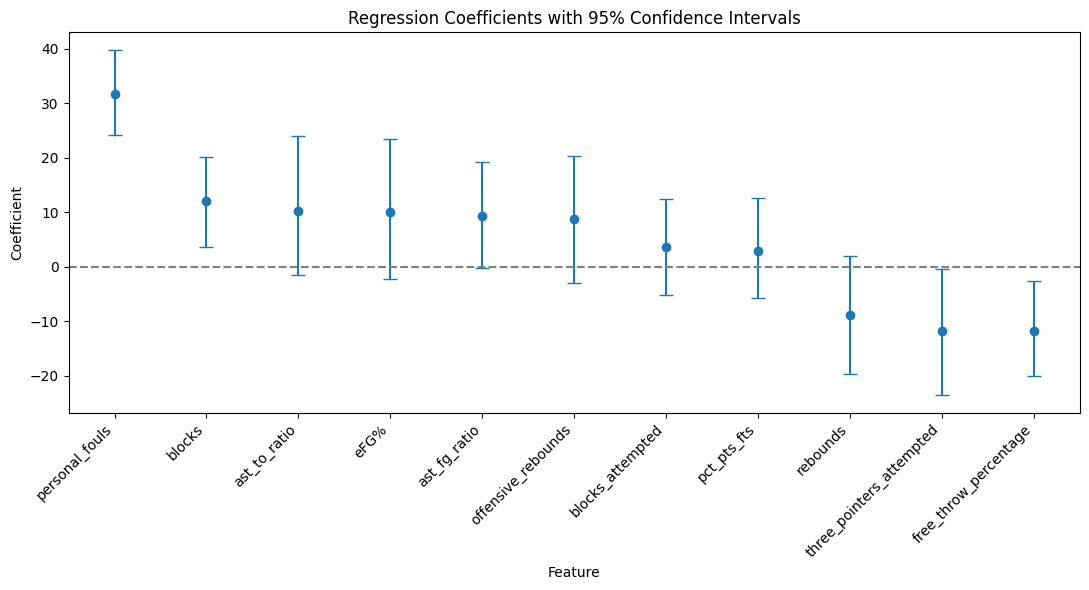

In [104]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_steals_era2)

In [105]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_steals_era2, steals_feats_era2, False)

A 32.094 unit increase in personal_fouls results in an approximate 7.270 change in the target variable.
A 7.805 unit increase in blocks results in an approximate 1.477 change in the target variable.
A 46.503 unit increase in three_pointers_attempted results in an approximate -1.051 change in the target variable.
A 0.015 unit increase in free_throw_percentage results in an approximate -5.974 change in the target variable.


In [106]:
# Continue with secondary feature regression analysis using pct_pts_fts as the target variable

In [107]:
# Check the df_feats_master DataFrame
era2_feats_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  360 non-null    int64  
 1   three_point_percentage    360 non-null    float64
 2   free_throw_percentage     360 non-null    float64
 3   offensive_rebounds        360 non-null    int64  
 4   rebounds                  360 non-null    int64  
 5   steals                    360 non-null    int64  
 6   blocks                    360 non-null    int64  
 7   blocks_attempted          360 non-null    int64  
 8   personal_fouls            360 non-null    int64  
 9   ast_to_ratio              360 non-null    float64
 10  pct_pts_fts               360 non-null    float64
 11  ast_fg_ratio              360 non-null    float64
 12  eFG%                      360 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 39.4 KB


In [108]:
# Drop the target variable from the features
ppfs_feats_era2 = era2_feats_master.drop(['pct_pts_fts'], axis=1)

ppfs_feats_era2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  360 non-null    int64  
 1   three_point_percentage    360 non-null    float64
 2   free_throw_percentage     360 non-null    float64
 3   offensive_rebounds        360 non-null    int64  
 4   rebounds                  360 non-null    int64  
 5   steals                    360 non-null    int64  
 6   blocks                    360 non-null    int64  
 7   blocks_attempted          360 non-null    int64  
 8   personal_fouls            360 non-null    int64  
 9   ast_to_ratio              360 non-null    float64
 10  ast_fg_ratio              360 non-null    float64
 11  eFG%                      360 non-null    float64
dtypes: float64(5), int64(7)
memory usage: 36.6 KB


In [109]:
# Generate the matrix for the base features of the full dataset minus the target feature and win percentage with the gen_corr_matrix function
ppfs_era2_feature_matrix, ppfs_era2_feat_str_correlations = gen_corr_matrix(ppfs_feats_era2)

ppfs_era2_feat_str_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [110]:
# Define the target variable for the dataset
y_ppfs_era2 = era2_feats_master['pct_pts_fts']

# Train the model for the dataset
results_ppfs_era2, ppfs_feats_era2 = gen_lasso_model(ppfs_feats_era2, y_ppfs_era2)

Best Alpha: 0.0001
Y Measurables: 
count    360.000000
mean       0.162355
std        0.016078
min        0.124383
25%        0.151984
50%        0.160695
75%        0.173018
max        0.220096
Name: pct_pts_fts, dtype: float64
Training RMSE: 0.0120625874693532, Testing RMSE: 0.012595873064425162
Training R^2: 0.45005166324085866, Testing R^2: 0.30635666488189073
Non-zero Coefficients: 
free_throw_percentage       0.005210
personal_fouls              0.001662
offensive_rebounds          0.001171
blocks_attempted            0.000071
ast_fg_ratio               -0.000633
three_point_percentage     -0.001933
three_pointers_attempted   -0.004186
ast_to_ratio               -0.006563
dtype: float64
Variance Inflation Factors: 
                    feature       vif
0  three_pointers_attempted  1.366785
1    three_point_percentage  1.494255
2     free_throw_percentage  1.377520
3        offensive_rebounds  1.626382
4          blocks_attempted  1.549006
5            personal_fouls  1.365888
6  

In [111]:
# With feature selection finalized, create a series of regression coefficients
ppfs_era2_coefficients = pd.Series(results_ppfs_era2['non_zero_coefficients'])

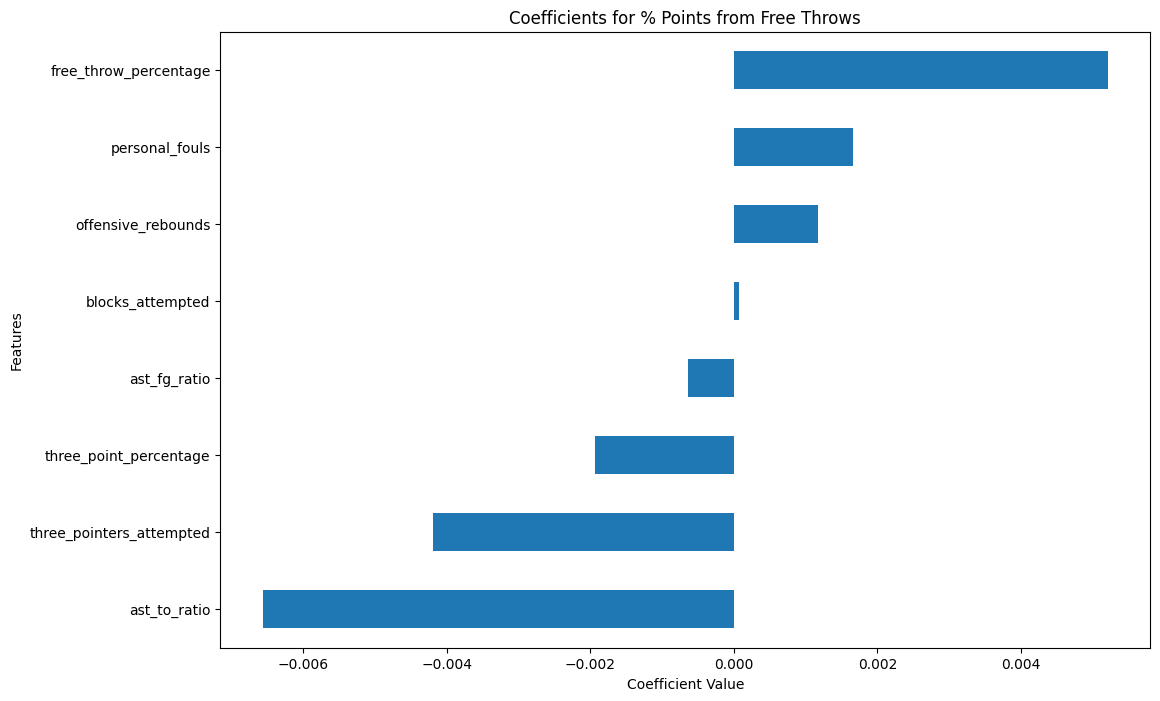

In [112]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(ppfs_era2_coefficients, '% Points from Free Throws')

In [113]:
# Generate bootstrap coefficients 
bootstrap_results_ppfs_era2 = gen_bootstrap_coefficients(
    results_ppfs_era2['model'], results_ppfs_era2['X'], results_ppfs_era2['y'], results_ppfs_era2['feature_names']
)

Average Y: 0.16235531367013437
Average Training RMSE: 0.011950666295543753, Average Testing RMSE: 0.012290829704219049
Average Training R^2: 0.44283675079468615, Average Testing R^2: 0.3931970607368685
Sorted Coefficients: 
                              Mean    StdDev  CI Lower  CI Upper
free_throw_percentage     0.004385  0.000976  0.002450  0.006295
personal_fouls            0.001833  0.000917  0.000000  0.003496
offensive_rebounds        0.000903  0.000809 -0.000469  0.002679
blocks_attempted          0.000501  0.000864 -0.001035  0.002225
ast_fg_ratio             -0.000705  0.000844 -0.002529  0.000891
three_point_percentage   -0.001767  0.000887 -0.003510  0.000000
three_pointers_attempted -0.004034  0.000891 -0.005694 -0.002290
ast_to_ratio             -0.006122  0.001117 -0.008436 -0.003943


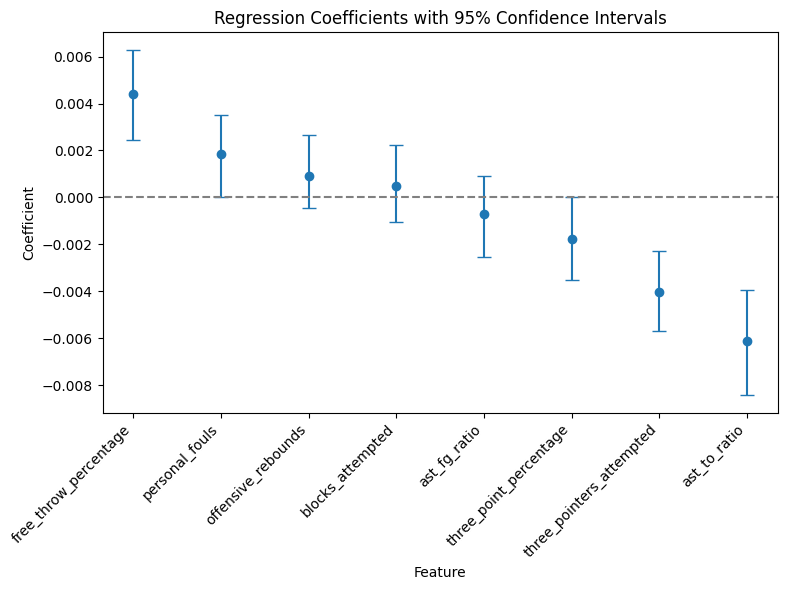

In [114]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_ppfs_era2)

In [115]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_ppfs_era2, ppfs_feats_era2)

A 0.015 unit increase in free_throw_percentage results in an approximate 0.0022 (or 0.22 percentage points) change in the target variable.
A 46.503 unit increase in three_pointers_attempted results in an approximate -0.0004 (or -0.04 percentage points) change in the target variable.
A 0.034 unit increase in ast_to_ratio results in an approximate -0.0010 (or -0.10 percentage points) change in the target variable.


In [116]:
# Continue with secondary feature regression analysis using three_pointers_attempted as the target variable

In [117]:
# Check the df_feats_master DataFrame
era2_feats_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  360 non-null    int64  
 1   three_point_percentage    360 non-null    float64
 2   free_throw_percentage     360 non-null    float64
 3   offensive_rebounds        360 non-null    int64  
 4   rebounds                  360 non-null    int64  
 5   steals                    360 non-null    int64  
 6   blocks                    360 non-null    int64  
 7   blocks_attempted          360 non-null    int64  
 8   personal_fouls            360 non-null    int64  
 9   ast_to_ratio              360 non-null    float64
 10  pct_pts_fts               360 non-null    float64
 11  ast_fg_ratio              360 non-null    float64
 12  eFG%                      360 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 39.4 KB


In [118]:
# Drop the target variable from the features
tpa_feats_era2 = era2_feats_master.drop(['three_pointers_attempted'], axis=1)

tpa_feats_era2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   three_point_percentage  360 non-null    float64
 1   free_throw_percentage   360 non-null    float64
 2   offensive_rebounds      360 non-null    int64  
 3   rebounds                360 non-null    int64  
 4   steals                  360 non-null    int64  
 5   blocks                  360 non-null    int64  
 6   blocks_attempted        360 non-null    int64  
 7   personal_fouls          360 non-null    int64  
 8   ast_to_ratio            360 non-null    float64
 9   pct_pts_fts             360 non-null    float64
 10  ast_fg_ratio            360 non-null    float64
 11  eFG%                    360 non-null    float64
dtypes: float64(6), int64(6)
memory usage: 36.6 KB


In [119]:
# Generate the matrix for the base features of the full dataset minus the target feature and win percentage with the gen_corr_matrix function
tpa_era2_feature_matrix, tpa_era2_feat_str_correlations = gen_corr_matrix(tpa_feats_era2)

tpa_era2_feat_str_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [120]:
# Drop the eFG% feature from the dataset
tpa_feats_era2 = tpa_feats_era2.drop(['eFG%'], axis=1)

tpa_feats_era2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   three_point_percentage  360 non-null    float64
 1   free_throw_percentage   360 non-null    float64
 2   offensive_rebounds      360 non-null    int64  
 3   rebounds                360 non-null    int64  
 4   steals                  360 non-null    int64  
 5   blocks                  360 non-null    int64  
 6   blocks_attempted        360 non-null    int64  
 7   personal_fouls          360 non-null    int64  
 8   ast_to_ratio            360 non-null    float64
 9   pct_pts_fts             360 non-null    float64
 10  ast_fg_ratio            360 non-null    float64
dtypes: float64(5), int64(6)
memory usage: 33.8 KB


In [121]:
# Define the target variable for the dataset
y_tpa_era2 = era2_feats_master['three_pointers_attempted']

# Train the model for the dataset
results_tpa_era2, tpa_feats_era2 = gen_lasso_model(tpa_feats_era2, y_tpa_era2)

Best Alpha: 0.1
Y Measurables: 
count     360.000000
mean     2325.136111
std       518.521259
min      1107.000000
25%      1954.750000
50%      2366.000000
75%      2680.250000
max      3721.000000
Name: three_pointers_attempted, dtype: float64
Training RMSE: 394.1578122575242, Testing RMSE: 444.29534373458705
Training R^2: 0.4112945774399125, Testing R^2: 0.2955108359056531
Non-zero Coefficients: 
ast_to_ratio              177.660940
rebounds                  172.932981
personal_fouls             78.800279
free_throw_percentage      47.278806
blocks_attempted           12.854113
ast_fg_ratio               -7.759793
three_point_percentage    -23.201397
steals                    -36.862266
blocks                    -82.854143
offensive_rebounds       -137.305642
pct_pts_fts              -144.630828
dtype: float64
Variance Inflation Factors: 
                   feature       vif
0   three_point_percentage  1.555987
1    free_throw_percentage  1.551359
2       offensive_rebounds  2.3884

In [122]:
# With feature selection finalized, create a series of regression coefficients
tpa_era2_coefficients = pd.Series(results_tpa_era2['non_zero_coefficients'])

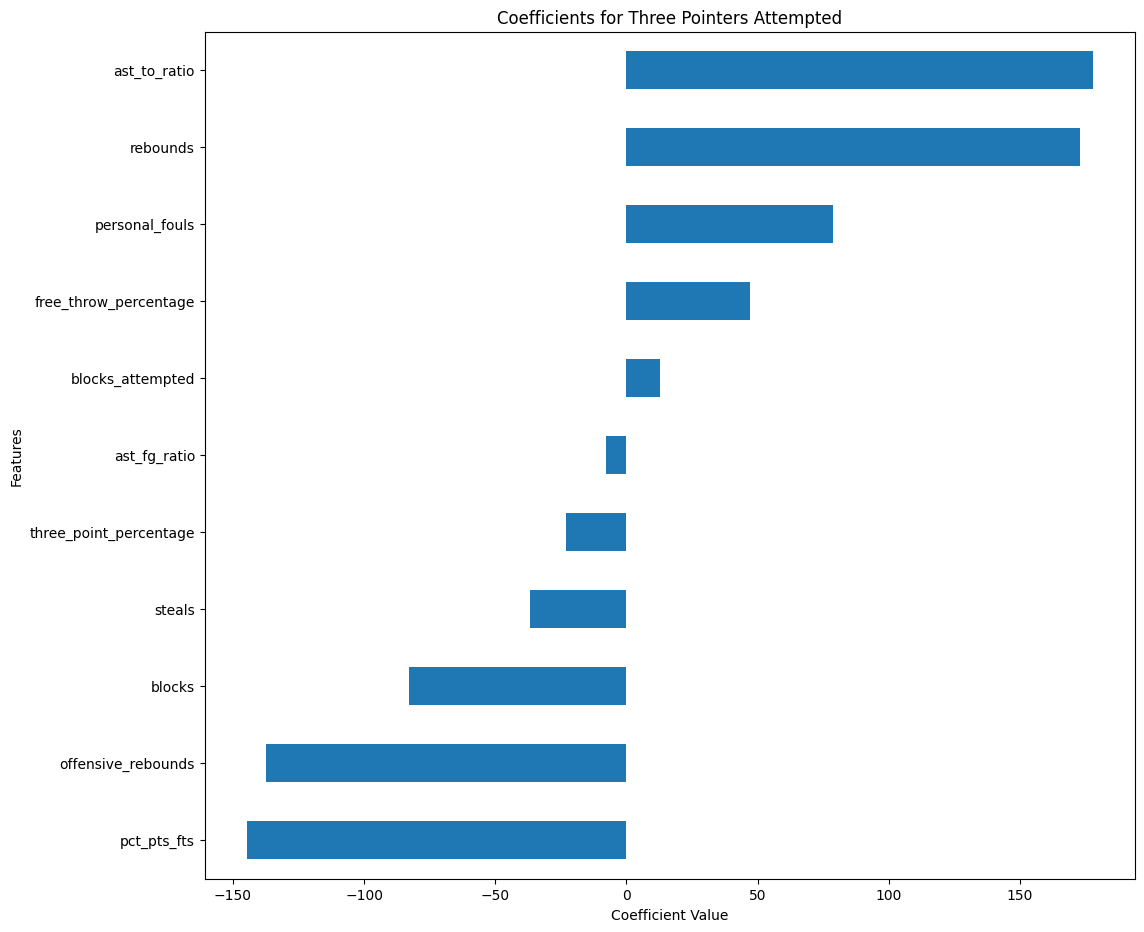

In [123]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(tpa_era2_coefficients, 'Three Pointers Attempted')

In [124]:
# Generate bootstrap coefficients 
bootstrap_results_tpa_era2 = gen_bootstrap_coefficients(
    results_tpa_era2['model'], results_tpa_era2['X'], results_tpa_era2['y'], results_tpa_era2['feature_names']
)

Average Y: 2325.136111111111
Average Training RMSE: 393.22581674630067, Average Testing RMSE: 408.27985875734464
Average Training R^2: 0.41780621248838146, Average Testing R^2: 0.3621460274158095
Sorted Coefficients: 
                              Mean     StdDev    CI Lower    CI Upper
rebounds                177.538780  32.101808  114.691190  240.157685
ast_to_ratio            166.673184  38.188996   92.369936  245.647357
personal_fouls           64.497399  30.752481    4.509670  127.030433
free_throw_percentage    39.354907  29.909189  -16.181795  100.721823
ast_fg_ratio              5.331561  31.361563  -58.899347   61.338399
blocks_attempted          0.501747  28.262188  -55.205542   54.486799
three_point_percentage  -41.572516  29.005490  -96.929296   16.880366
steals                  -41.803607  31.329331 -103.202582   20.828119
blocks                  -68.258441  24.256021 -115.552000  -18.627771
offensive_rebounds     -139.743174  34.845105 -210.230549  -78.003759
pct_pts_fts 

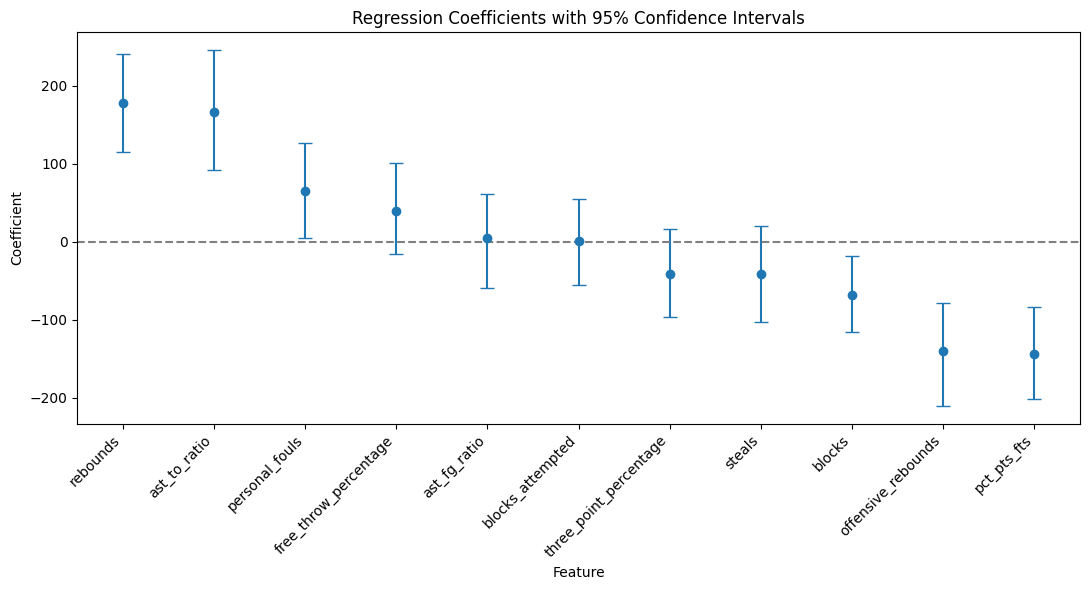

In [125]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_tpa_era2)

In [126]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_tpa_era2, tpa_feats_era2, False)

A 70.114 unit increase in rebounds results in an approximate 55.809 change in the target variable.
A 0.034 unit increase in ast_to_ratio results in an approximate 26.219 change in the target variable.
A 32.094 unit increase in personal_fouls results in an approximate 14.767 change in the target variable.
A 7.805 unit increase in blocks results in an approximate -8.381 change in the target variable.
A 16.701 unit increase in offensive_rebounds results in an approximate -20.933 change in the target variable.
A 0.003 unit increase in pct_pts_fts results in an approximate -28.975 change in the target variable.


In [127]:
# Continue with secondary feature regression analysis using personal_fouls as the target variable

In [128]:
# Check the df_feats_master DataFrame
era2_feats_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  360 non-null    int64  
 1   three_point_percentage    360 non-null    float64
 2   free_throw_percentage     360 non-null    float64
 3   offensive_rebounds        360 non-null    int64  
 4   rebounds                  360 non-null    int64  
 5   steals                    360 non-null    int64  
 6   blocks                    360 non-null    int64  
 7   blocks_attempted          360 non-null    int64  
 8   personal_fouls            360 non-null    int64  
 9   ast_to_ratio              360 non-null    float64
 10  pct_pts_fts               360 non-null    float64
 11  ast_fg_ratio              360 non-null    float64
 12  eFG%                      360 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 39.4 KB


In [129]:
# Drop the target variable from the features
pf_feats_era2 = era2_feats_master.drop(['personal_fouls'], axis=1)

pf_feats_era2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  360 non-null    int64  
 1   three_point_percentage    360 non-null    float64
 2   free_throw_percentage     360 non-null    float64
 3   offensive_rebounds        360 non-null    int64  
 4   rebounds                  360 non-null    int64  
 5   steals                    360 non-null    int64  
 6   blocks                    360 non-null    int64  
 7   blocks_attempted          360 non-null    int64  
 8   ast_to_ratio              360 non-null    float64
 9   pct_pts_fts               360 non-null    float64
 10  ast_fg_ratio              360 non-null    float64
 11  eFG%                      360 non-null    float64
dtypes: float64(6), int64(6)
memory usage: 36.6 KB


In [130]:
# Generate the matrix for the base features of the full dataset minus the target feature and win percentage with the gen_corr_matrix function
pf_era2_feature_matrix, pf_era2_feat_str_correlations = gen_corr_matrix(pf_feats_era2)

pf_era2_feat_str_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [131]:
# Define the target variable for the dataset
y_pf_era2 = era2_feats_master['personal_fouls']

# Train the model for the dataset
results_pf_era2, pf_feats_era2 = gen_lasso_model(pf_feats_era2, y_pf_era2)

Best Alpha: 0.1
Y Measurables: 
count     360.000000
mean     1604.700000
std       140.370477
min      1188.000000
25%      1509.000000
50%      1612.000000
75%      1701.000000
max      2030.000000
Name: personal_fouls, dtype: float64
Training RMSE: 104.3899260563464, Testing RMSE: 111.9280122128648
Training R^2: 0.4426467326122183, Testing R^2: 0.35513302840110306
Non-zero Coefficients: 
steals                      48.526737
rebounds                    31.931921
three_pointers_attempted    31.264031
pct_pts_fts                 14.213394
three_point_percentage      14.162231
offensive_rebounds           8.866744
free_throw_percentage        8.619370
ast_fg_ratio                 7.410192
blocks_attempted             6.294935
blocks                       3.826710
eFG%                       -20.598486
ast_to_ratio               -56.945487
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  2.991970
1     three_point_percentage

In [132]:
# Drop the three_point_percentage feature to recude vif scores
pf_feats_era2 = pf_feats_era2.drop(['three_point_percentage'], axis=1)

pf_feats_era2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  360 non-null    int64  
 1   free_throw_percentage     360 non-null    float64
 2   offensive_rebounds        360 non-null    int64  
 3   rebounds                  360 non-null    int64  
 4   steals                    360 non-null    int64  
 5   blocks                    360 non-null    int64  
 6   blocks_attempted          360 non-null    int64  
 7   ast_to_ratio              360 non-null    float64
 8   pct_pts_fts               360 non-null    float64
 9   ast_fg_ratio              360 non-null    float64
 10  eFG%                      360 non-null    float64
dtypes: float64(5), int64(6)
memory usage: 33.8 KB


In [133]:
# Retrain the model
results_pf_era2, pf_feats_era2 = gen_lasso_model(pf_feats_era2, y_pf_era2)

Best Alpha: 0.1
Y Measurables: 
count     360.000000
mean     1604.700000
std       140.370477
min      1188.000000
25%      1509.000000
50%      1612.000000
75%      1701.000000
max      2030.000000
Name: personal_fouls, dtype: float64
Training RMSE: 104.81892819037397, Testing RMSE: 111.63203590946115
Training R^2: 0.43805630772876814, Testing R^2: 0.3585390209090561
Non-zero Coefficients: 
steals                      48.330412
rebounds                    32.620561
three_pointers_attempted    24.320115
pct_pts_fts                 12.169464
free_throw_percentage       11.386432
offensive_rebounds           9.931643
ast_fg_ratio                 7.511929
blocks_attempted             4.385537
blocks                       3.966495
eFG%                        -8.184035
ast_to_ratio               -58.725612
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  2.472055
1      free_throw_percentage  1.462848
2         offensive_rebou

In [134]:
# With feature selection finalized, create a series of regression coefficients
pf_era2_coefficients = pd.Series(results_pf_era2['non_zero_coefficients'])

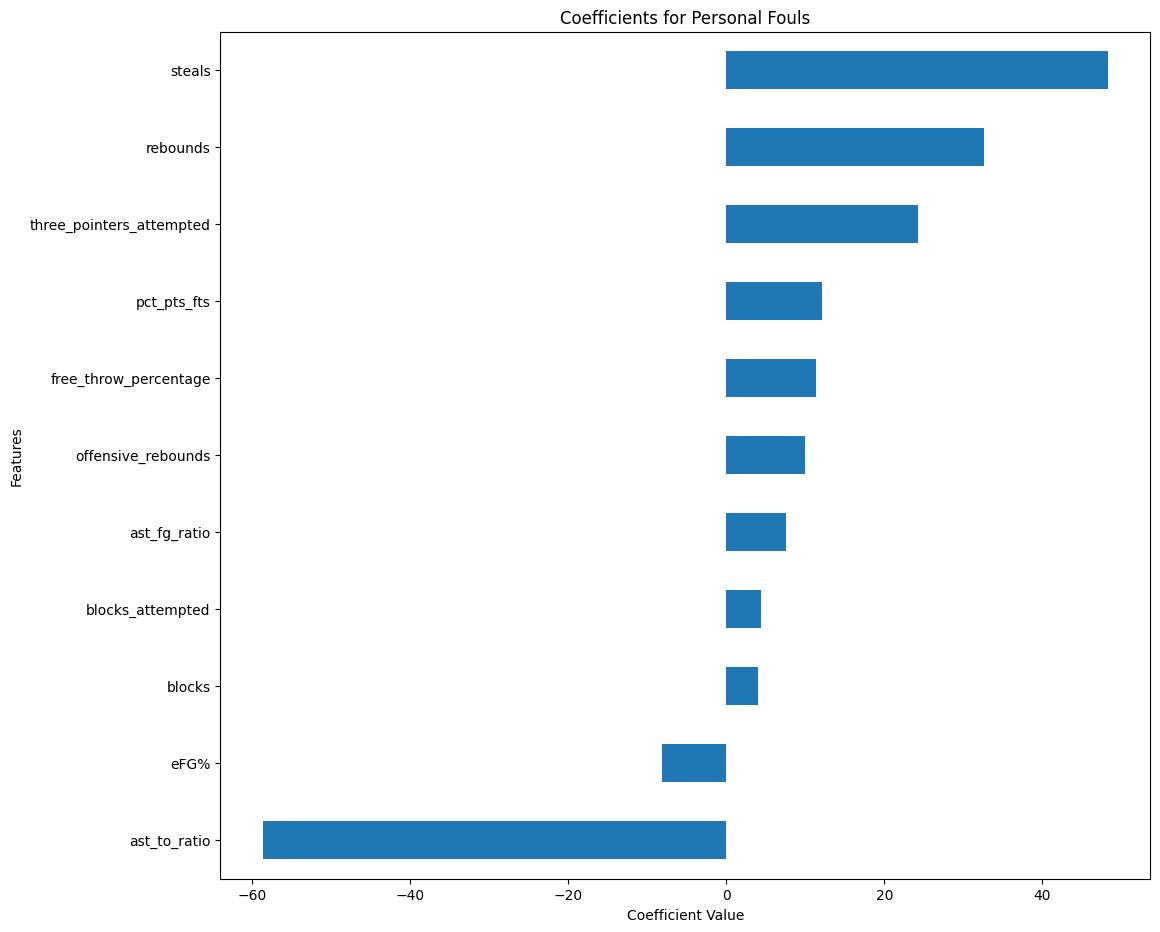

In [135]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(pf_era2_coefficients, 'Personal Fouls')

In [136]:
# Generate bootstrap coefficients 
bootstrap_results_pf_era2 = gen_bootstrap_coefficients(
    results_pf_era2['model'], results_pf_era2['X'], results_pf_era2['y'], results_pf_era2['feature_names']
)

Average Y: 1604.7
Average Training RMSE: 103.10492982297876, Average Testing RMSE: 107.48373279841628
Average Training R^2: 0.4551246550537418, Average Testing R^2: 0.3887711401153463
Sorted Coefficients: 
                               Mean     StdDev   CI Lower   CI Upper
steals                    51.459445   6.226261  38.980409  63.156293
rebounds                  35.344748   9.325711  17.412574  54.103983
three_pointers_attempted  19.424569   9.671612   0.354819  38.094228
free_throw_percentage     13.718144   7.966691  -1.839263  29.200343
pct_pts_fts               11.651556   9.357613  -5.484731  29.873597
offensive_rebounds        10.864682  10.373113  -7.797799  31.563816
ast_fg_ratio               4.018766   7.821740 -12.409893  18.911258
blocks_attempted           2.252700   8.890076 -14.597780  20.685138
blocks                     0.037916   7.312951 -14.086915  13.941686
eFG%                      -7.789736  12.772558 -31.259378  17.633869
ast_to_ratio             -52.229315

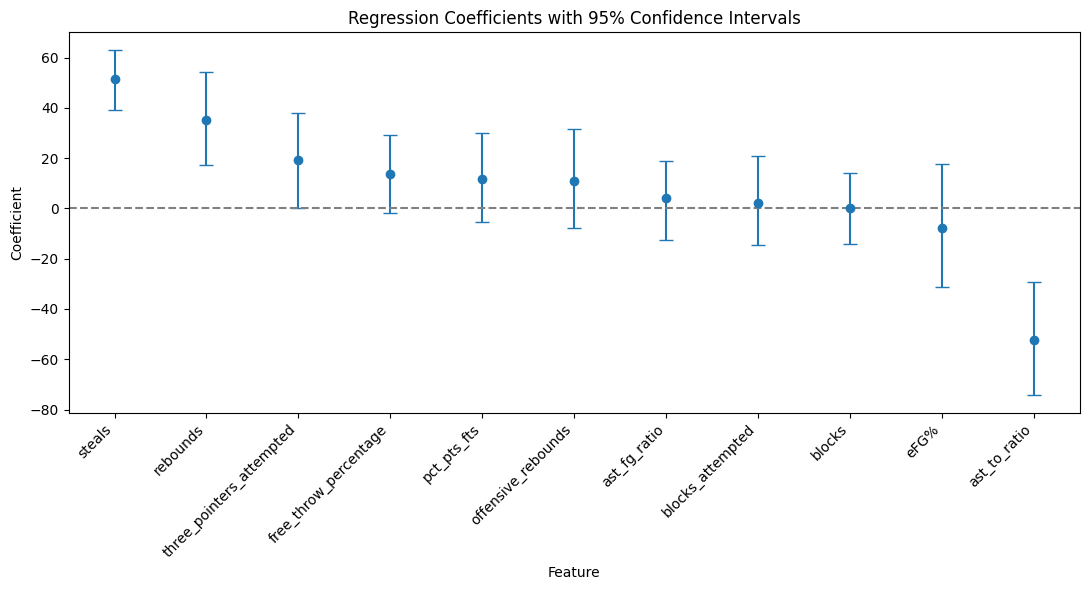

In [137]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_pf_era2)

In [138]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_pf_era2, pf_feats_era2, False)

A 12.265 unit increase in steals results in an approximate 8.805 change in the target variable.
A 70.114 unit increase in rebounds results in an approximate 11.110 change in the target variable.
A 46.503 unit increase in three_pointers_attempted results in an approximate 1.744 change in the target variable.
A 0.034 unit increase in ast_to_ratio results in an approximate -8.216 change in the target variable.


In [139]:
# Continue with secondary feature regression analysis using blocks_attempted as the target variable

In [140]:
# Check the df_feats_master DataFrame
era2_feats_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  360 non-null    int64  
 1   three_point_percentage    360 non-null    float64
 2   free_throw_percentage     360 non-null    float64
 3   offensive_rebounds        360 non-null    int64  
 4   rebounds                  360 non-null    int64  
 5   steals                    360 non-null    int64  
 6   blocks                    360 non-null    int64  
 7   blocks_attempted          360 non-null    int64  
 8   personal_fouls            360 non-null    int64  
 9   ast_to_ratio              360 non-null    float64
 10  pct_pts_fts               360 non-null    float64
 11  ast_fg_ratio              360 non-null    float64
 12  eFG%                      360 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 39.4 KB


In [141]:
# Drop the target variable from the features
ba_feats_era2 = era2_feats_master.drop(['blocks_attempted'], axis=1)

ba_feats_era2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  360 non-null    int64  
 1   three_point_percentage    360 non-null    float64
 2   free_throw_percentage     360 non-null    float64
 3   offensive_rebounds        360 non-null    int64  
 4   rebounds                  360 non-null    int64  
 5   steals                    360 non-null    int64  
 6   blocks                    360 non-null    int64  
 7   personal_fouls            360 non-null    int64  
 8   ast_to_ratio              360 non-null    float64
 9   pct_pts_fts               360 non-null    float64
 10  ast_fg_ratio              360 non-null    float64
 11  eFG%                      360 non-null    float64
dtypes: float64(6), int64(6)
memory usage: 36.6 KB


In [142]:
# Generate the matrix for the base features of the full dataset minus the target feature and win percentage with the gen_corr_matrix function
ba_era2_feature_matrix, ba_era2_feat_str_correlations = gen_corr_matrix(ba_feats_era2)

ba_era2_feat_str_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [143]:
# Define the target variable for the dataset
y_ba_era2 = era2_feats_master['blocks_attempted']

# Train the model for the dataset
results_ba_era2, ba_feats_era2 = gen_lasso_model(ba_feats_era2, y_ba_era2)

Best Alpha: 0.1
Y Measurables: 
count    360.000000
mean     390.272222
std       59.791870
min      245.000000
25%      347.750000
50%      389.000000
75%      427.000000
max      565.000000
Name: blocks_attempted, dtype: float64
Training RMSE: 46.199441997206534, Testing RMSE: 50.794657708995445
Training R^2: 0.3918916636048563, Testing R^2: 0.31834626628213036
Non-zero Coefficients: 
offensive_rebounds          18.391780
three_pointers_attempted    12.391653
ast_fg_ratio                 9.707992
free_throw_percentage        8.428345
steals                       4.023029
personal_fouls               2.910898
blocks                       1.988722
pct_pts_fts                  1.565028
ast_to_ratio                -6.027496
three_point_percentage     -11.975562
eFG%                       -20.907956
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  2.831722
1     three_point_percentage  2.164612
2      free_throw_percentage  1

In [144]:
# Drop the three_point_percentage feature to recude vif scores
ba_feats_era2 = ba_feats_era2.drop(['three_point_percentage'], axis=1)

ba_feats_era2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 359
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  360 non-null    int64  
 1   free_throw_percentage     360 non-null    float64
 2   offensive_rebounds        360 non-null    int64  
 3   steals                    360 non-null    int64  
 4   blocks                    360 non-null    int64  
 5   personal_fouls            360 non-null    int64  
 6   ast_to_ratio              360 non-null    float64
 7   pct_pts_fts               360 non-null    float64
 8   ast_fg_ratio              360 non-null    float64
 9   eFG%                      360 non-null    float64
dtypes: float64(5), int64(5)
memory usage: 30.9 KB


In [145]:
# Retrain the model
results_ba_era2, ba_feats_era2 = gen_lasso_model(ba_feats_era2, y_ba_era2)

Best Alpha: 0.1
Y Measurables: 
count    360.000000
mean     390.272222
std       59.791870
min      245.000000
25%      347.750000
50%      389.000000
75%      427.000000
max      565.000000
Name: blocks_attempted, dtype: float64
Training RMSE: 46.84492425924947, Testing RMSE: 51.18778020448533
Training R^2: 0.3747804075063923, Testing R^2: 0.30775419176691077
Non-zero Coefficients: 
three_pointers_attempted    18.884549
offensive_rebounds          17.828661
ast_fg_ratio                 9.973088
free_throw_percentage        6.357701
steals                       4.672912
pct_pts_fts                  3.464356
personal_fouls               1.961234
blocks                       1.859682
ast_to_ratio                -5.104435
eFG%                       -32.389039
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  2.271590
1      free_throw_percentage  1.461438
2         offensive_rebounds  1.607441
3                     steals  1.

In [146]:
# With feature selection finalized, create a series of regression coefficients
ba_era2_coefficients = pd.Series(results_ba_era2['non_zero_coefficients'])

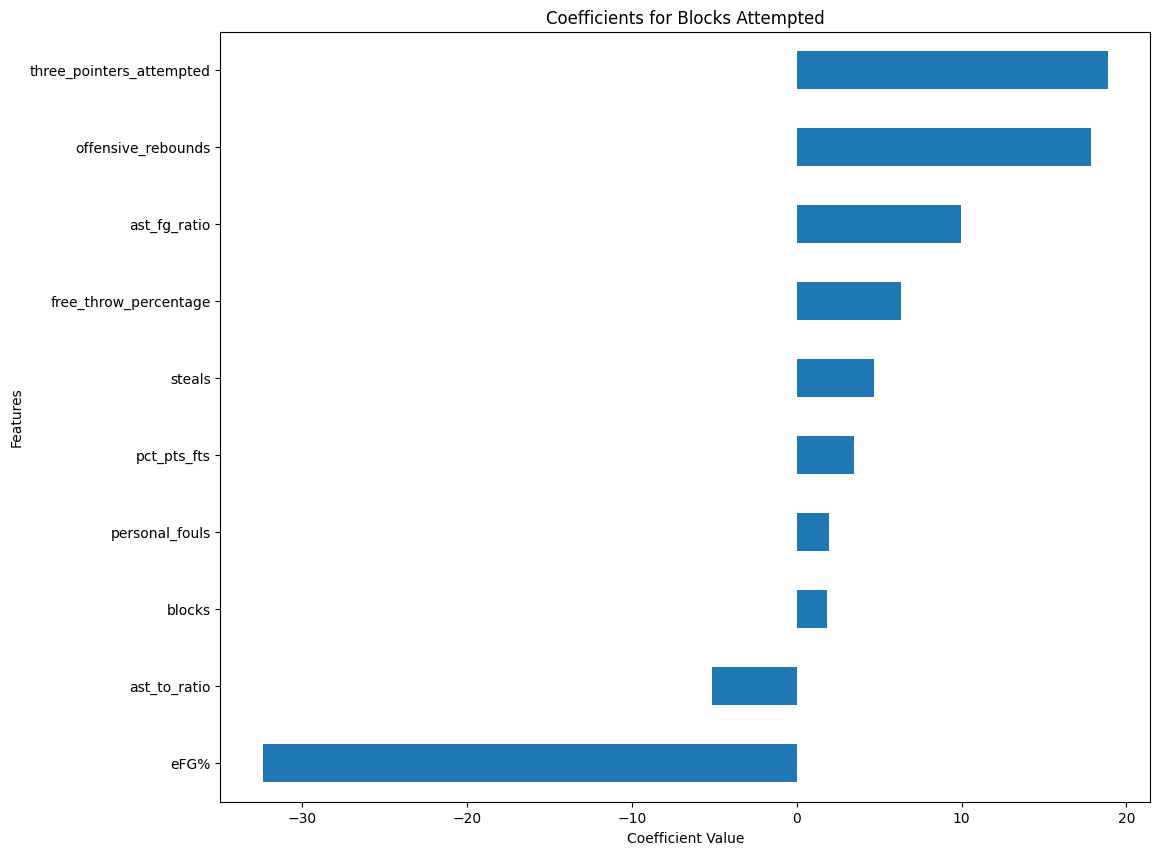

In [147]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(ba_era2_coefficients, 'Blocks Attempted')

In [148]:
# Generate bootstrap coefficients 
bootstrap_results_ba_era2 = gen_bootstrap_coefficients(
    results_ba_era2['model'], results_ba_era2['X'], results_ba_era2['y'], results_ba_era2['feature_names']
)

Average Y: 390.27222222222224
Average Training RMSE: 46.51884555420859, Average Testing RMSE: 48.427470712803085
Average Training R^2: 0.38751684817486237, Average Testing R^2: 0.3174826487372208
Sorted Coefficients: 
                               Mean    StdDev   CI Lower   CI Upper
offensive_rebounds        17.733255  3.888768   9.788438  24.551554
three_pointers_attempted  16.186273  4.298784   7.527101  24.069187
ast_fg_ratio               7.893344  3.449477   1.182799  14.829823
free_throw_percentage      6.033873  4.136390  -2.230634  13.743203
pct_pts_fts                4.308503  4.073252  -3.256741  12.088974
steals                     2.968150  3.572705  -3.913948   9.688626
blocks                     1.828198  3.246429  -4.419854   8.304465
personal_fouls             1.042484  3.729455  -6.180783   8.557370
ast_to_ratio              -4.916477  5.219690 -15.433974   5.289177
eFG%                     -30.704103  5.311760 -40.926644 -19.813584


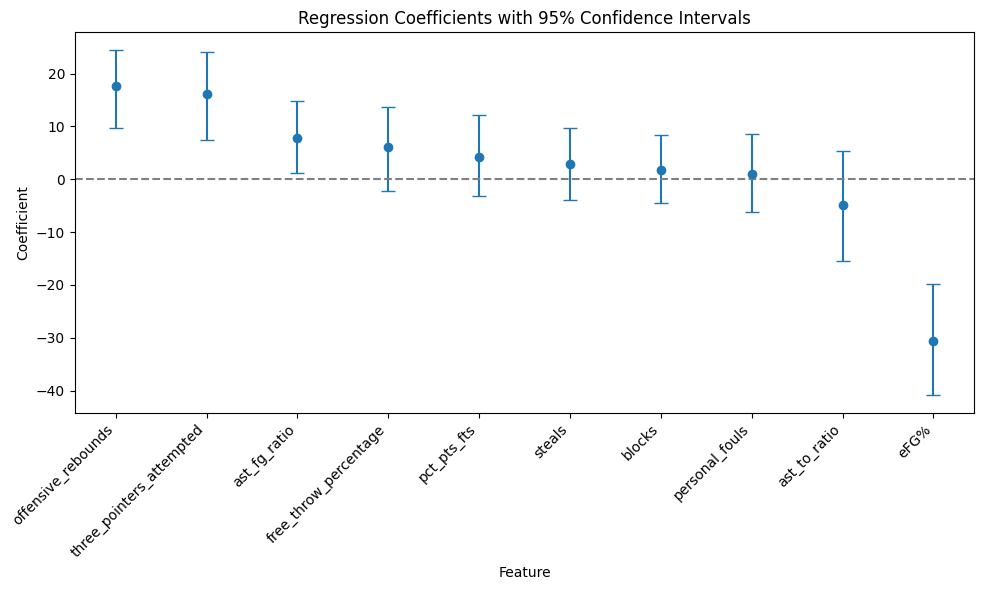

In [149]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_ba_era2)

In [150]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_ba_era2, ba_feats_era2, False)

A 16.701 unit increase in offensive_rebounds results in an approximate 2.656 change in the target variable.
A 46.503 unit increase in three_pointers_attempted results in an approximate 1.454 change in the target variable.
A 0.012 unit increase in ast_fg_ratio results in an approximate 2.434 change in the target variable.
A 0.010 unit increase in eFG% results in an approximate -12.632 change in the target variable.
